In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [45]:
colonnes_a_supprimer = ['CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209','INDPARDCD','CRTOP_AG_IND_0038', 'CRTOP_IND_0038', 'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3', 'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite', 'secteur_activite_bis' ]
samples = samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)
sample['datdelhis'] = sample['datdelhis'] % 100
sample['datdelhis'] = sample['datdelhis'].astype(str)

In [46]:
train_score = pd.read_excel('../data/train_score.xlsx')
test_score = pd.read_excel('../data/test_score.xlsx')
oot_score = pd.read_excel('../data/oot_score.xlsx')
sample_score = pd.concat([train_score, test_score, oot_score], ignore_index=True)

train['Score'] = train_score['Score']
test['Score'] = test_score['Score']
oot['Score'] = oot_score['Score']
sample['Score'] = sample_score['Score']

In [47]:
def discretize_feature_based_on_tree(feature, n_bins, custom_thresholds=None):
    """
    Discrétise une caractéristique (feature) basée sur un classifieur d'arbre de décision,
    avec possibilité de réajuster les seuils automatiquement ou manuellement.

    Paramètres :
    - feature : str, le nom de la caractéristique à discrétiser.
    - n_bins : int, le nombre de feuilles dans l'arbre de décision.
    - custom_thresholds : list (optionnelle), liste de seuils définis manuellement.

    Retourne :
    - Le nom de la nouvelle colonne discrétisée.
    """
    target = 'DDefaut_NDB'
    
    # Extraire les données de la caractéristique et de la cible
    X = train[[feature]].values
    y = train[target].values

    # Initialiser le classifieur d'arbre de décision
    clf = DecisionTreeClassifier(
        max_leaf_nodes=n_bins,
        random_state=42,
        min_samples_split=0.05,
    )
    
    # Entraîner le modèle
    clf.fit(X, y)

    # Obtenir les seuils triés ou utiliser les seuils personnalisés
    if custom_thresholds:
        thresholds = np.array(custom_thresholds)
    else:
        thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])
    
    def assign_class(value):
        """
        Assigns a class to a value based on thresholds from the decision tree.
        """
        for i, threshold in enumerate(thresholds):
            if value <= threshold:
                return i
        return len(thresholds)

    # Apply discretization to the train data
    discretized_column = train[feature].apply(assign_class)
    discretized_column_name = f"{feature}_discretized"
    train[discretized_column_name] = discretized_column

    discretized_column = sample[feature].apply(assign_class)
    discretized_column_name = f"{feature}_discretized"
    sample[discretized_column_name] = discretized_column

    # Afficher les seuils et l'arbre pour vérification
    print(f"Seuils de coupure pour '{feature}' : {thresholds}")

    # Affichage de l'arbre
    plt.figure(figsize=(20, 10))
    plot_tree(clf, 
          feature_names=[feature], 
          filled=False, 
          rounded=True, 
          fontsize=12)
    plt.show()

    return discretized_column_name


Seuils de coupure pour 'CRTOC_IND_0015' : [ 3.5 27.5]


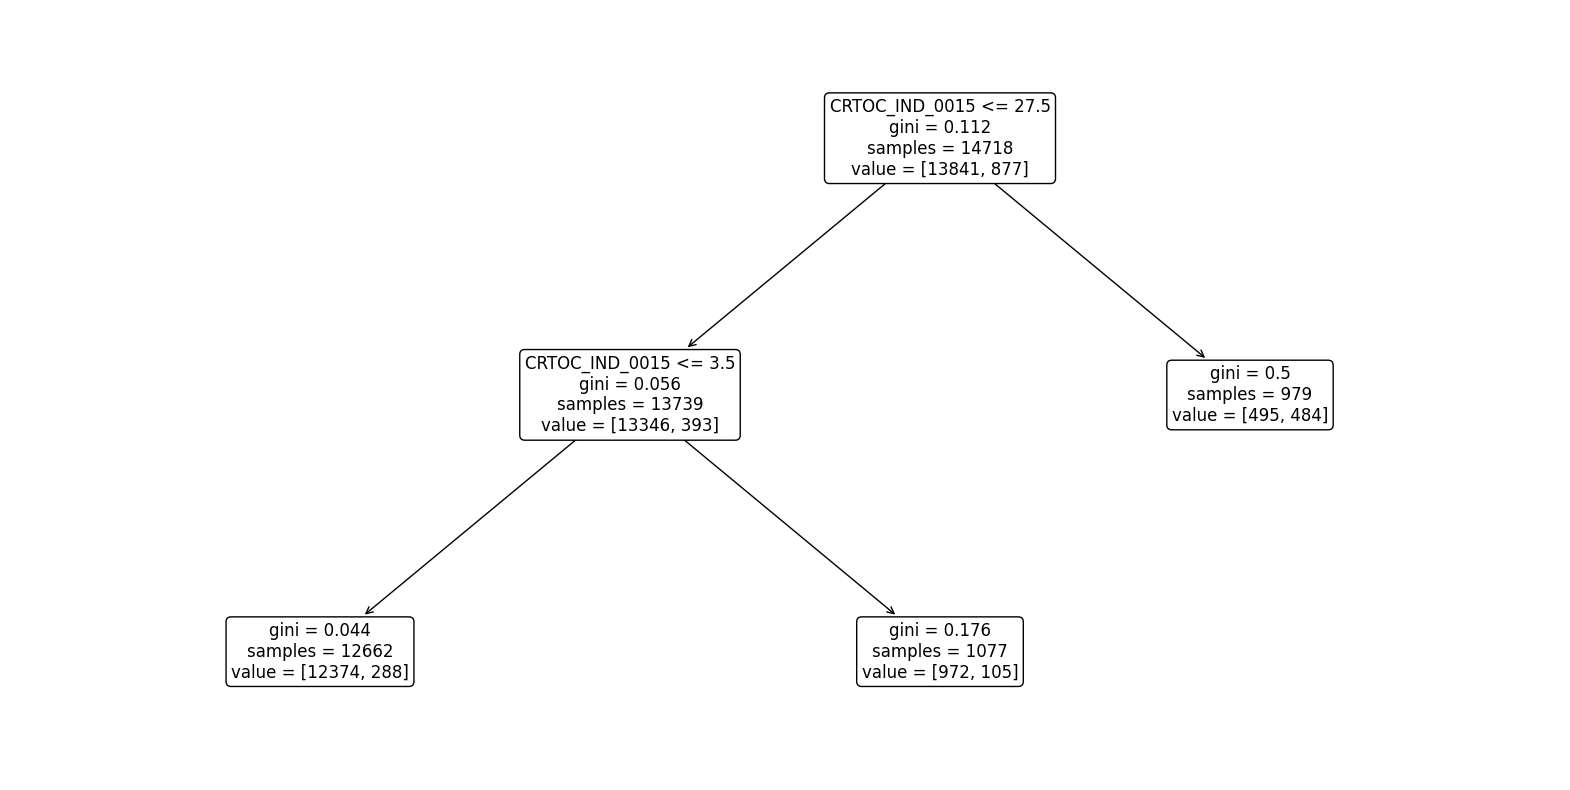

CRTOC_IND_0015_discretized
0    0.023063
1    0.099579
2    0.507349
Name: DDefaut_NDB, dtype: float64


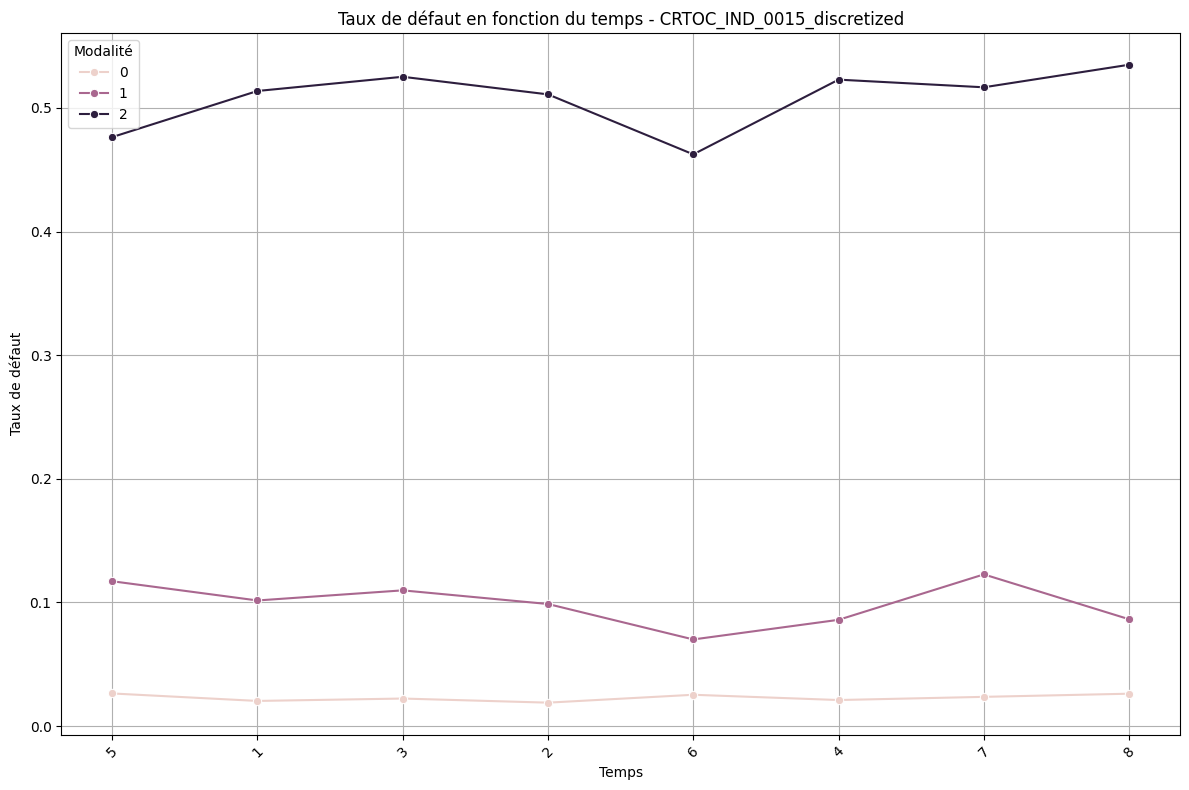

CRTOC_IND_0015_discretized
0    86.280639
1     7.235162
2     6.484199
Name: proportion, dtype: float64


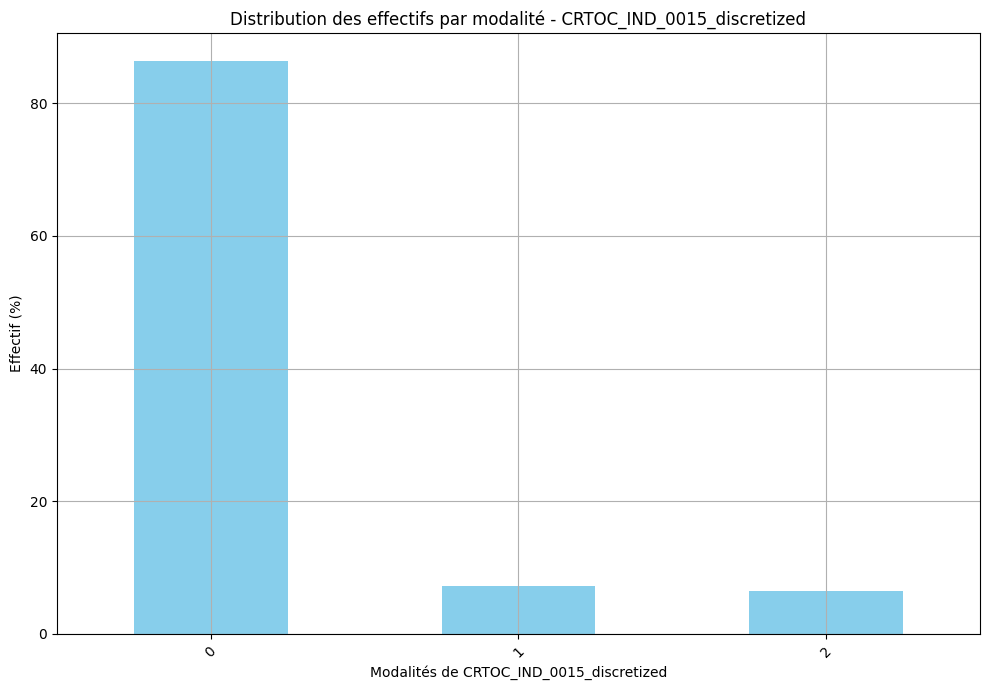

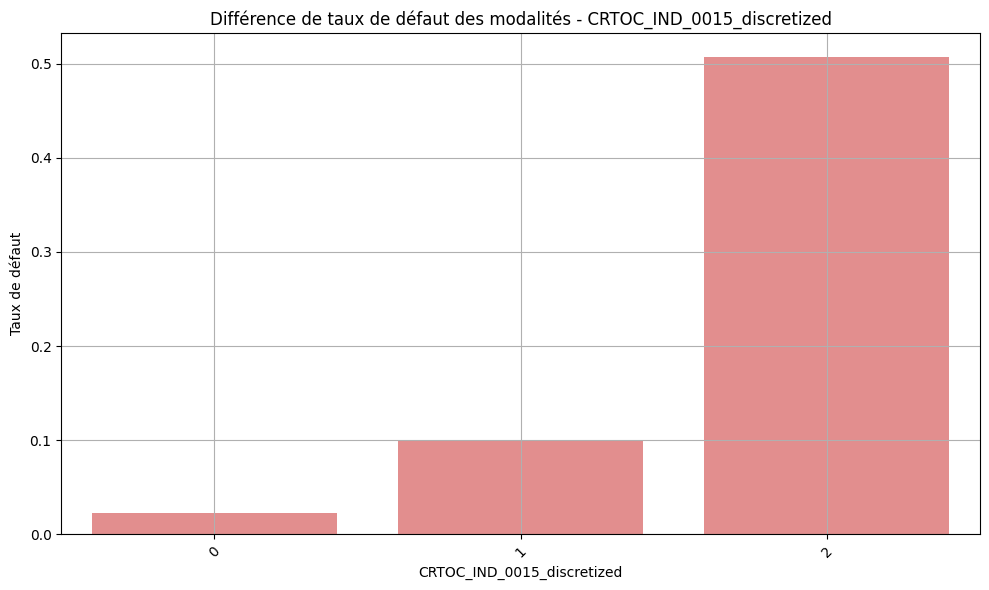

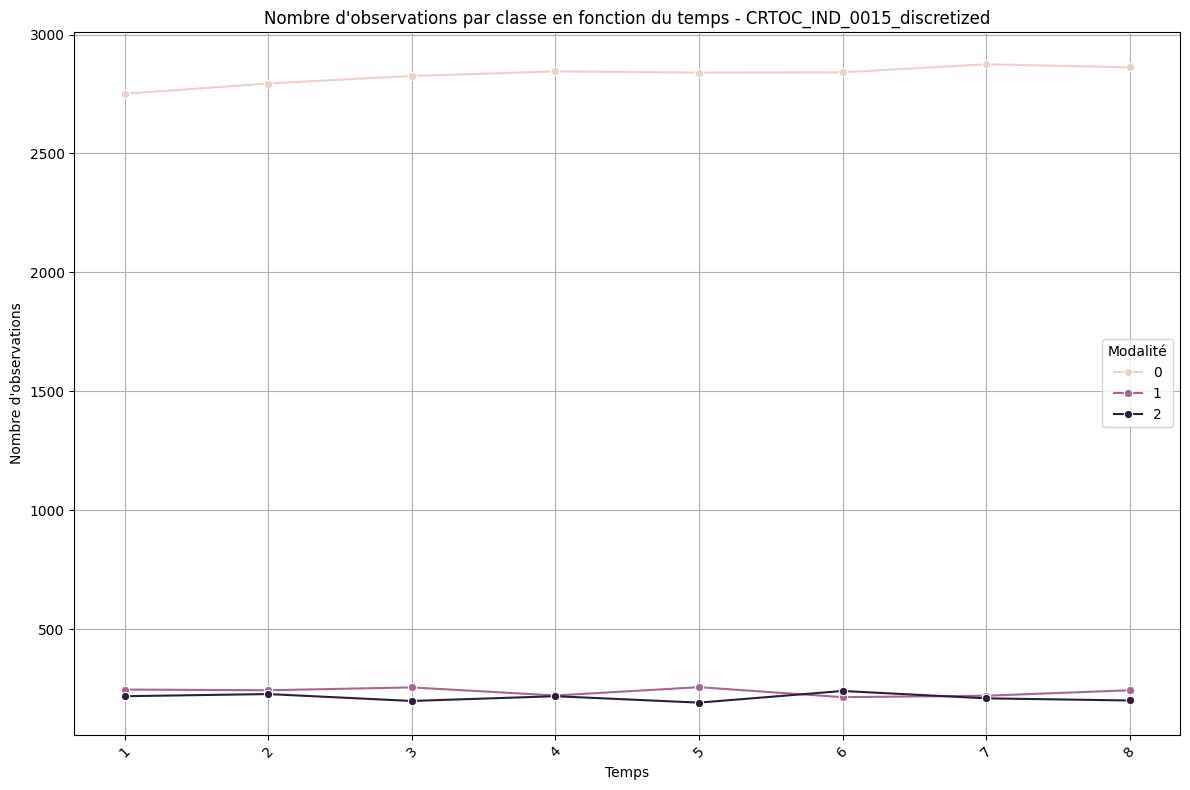

Seuils de coupure pour 'CRTOC_AG_LIGDEB_2T_IND_0015' : [-403533.5]


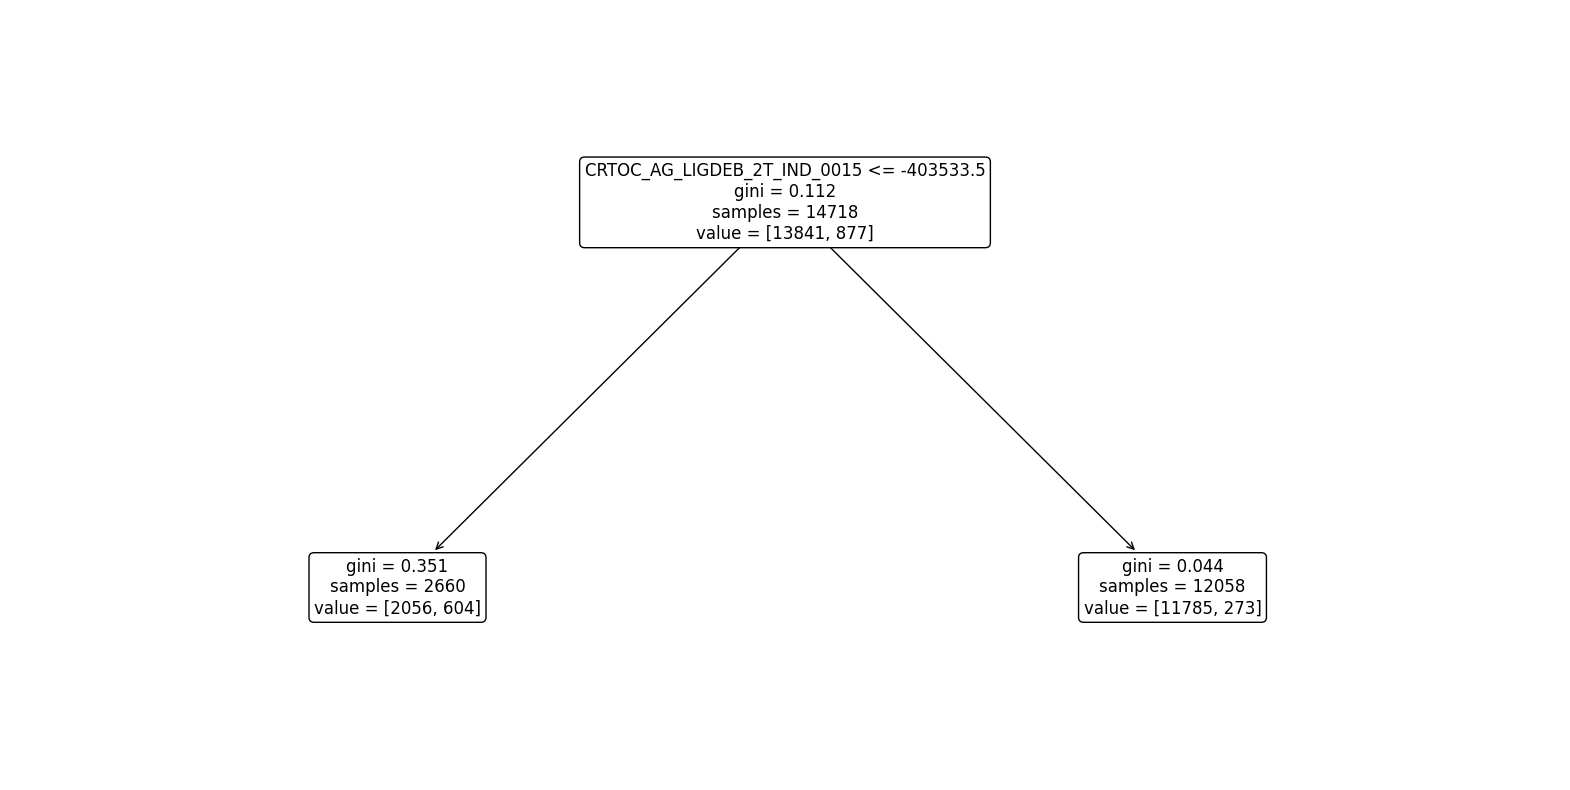

CRTOC_AG_LIGDEB_2T_IND_0015_discretized
1    0.023359
0    0.229762
Name: DDefaut_NDB, dtype: float64


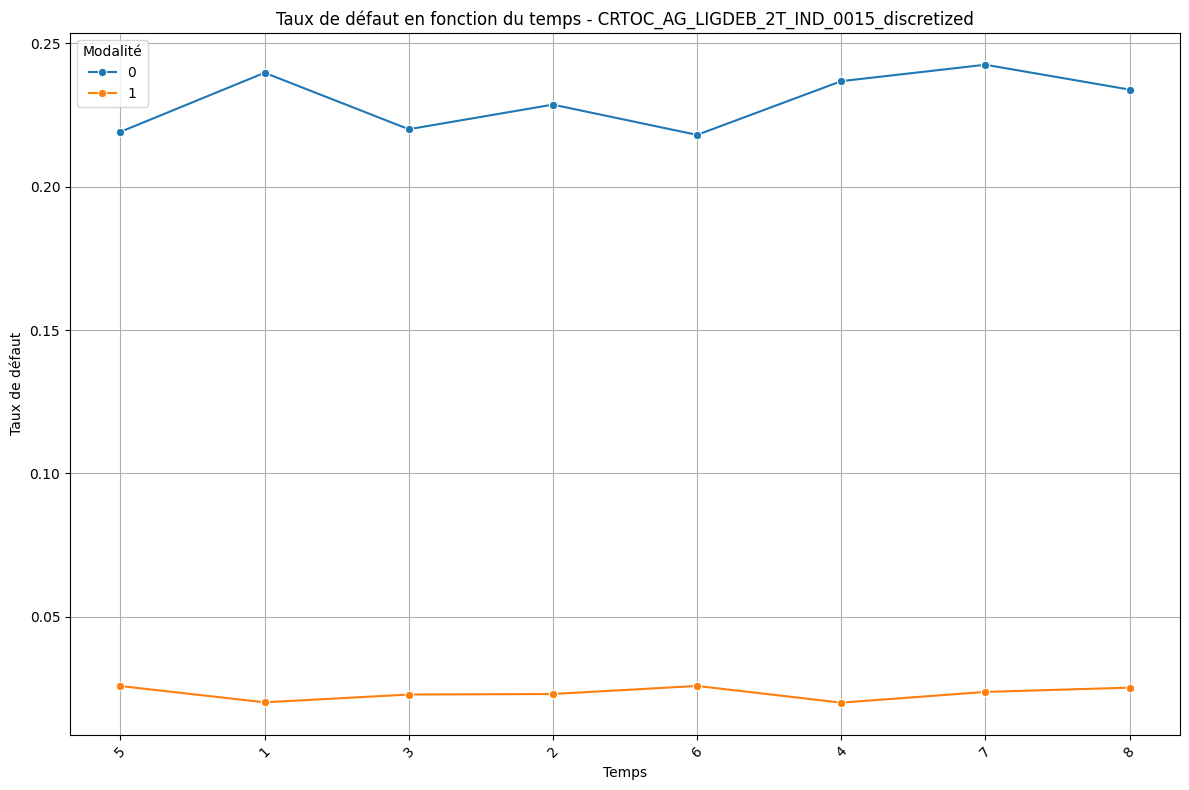

CRTOC_AG_LIGDEB_2T_IND_0015_discretized
1    82.247551
0    17.752449
Name: proportion, dtype: float64


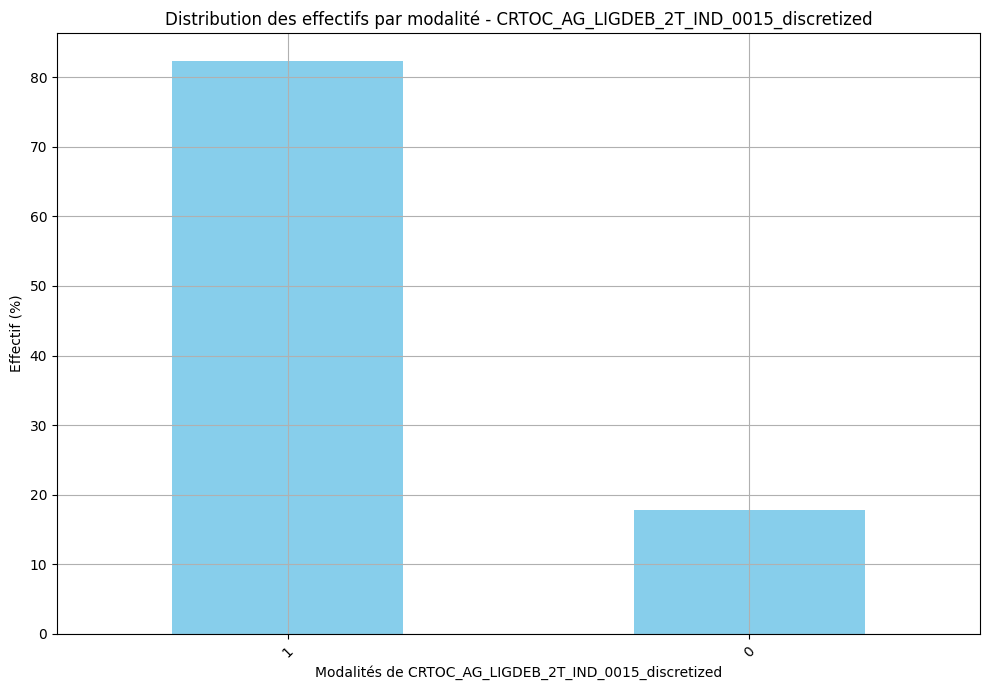

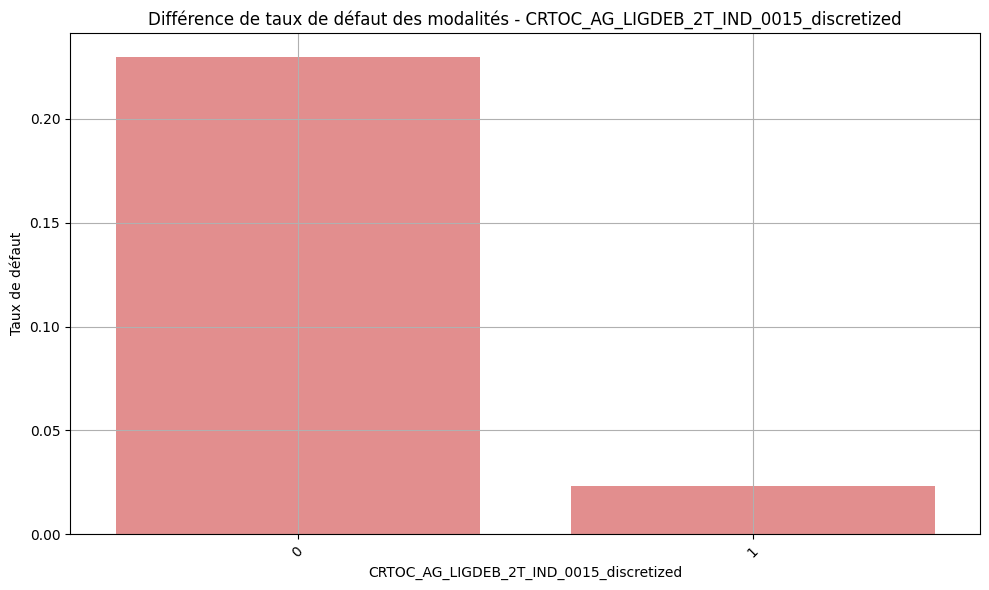

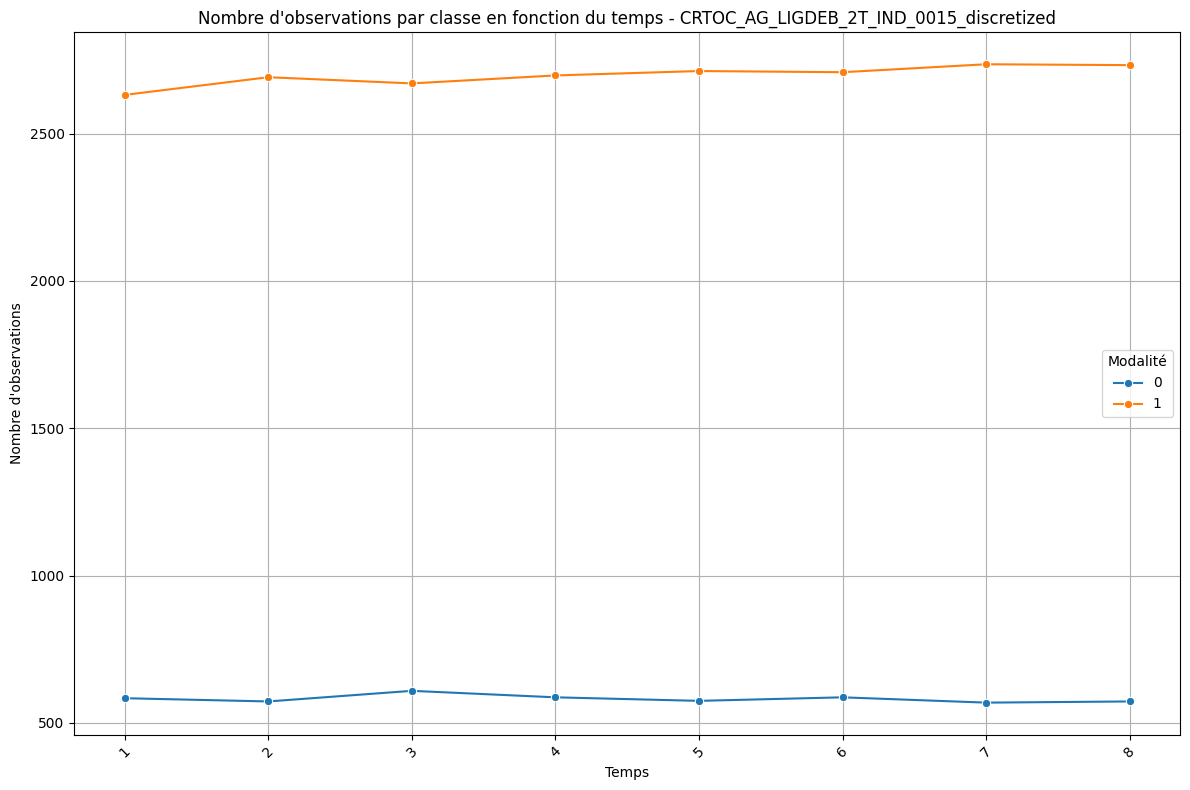

Seuils de coupure pour 'CRTOC_IND_0164' : [-3950.]


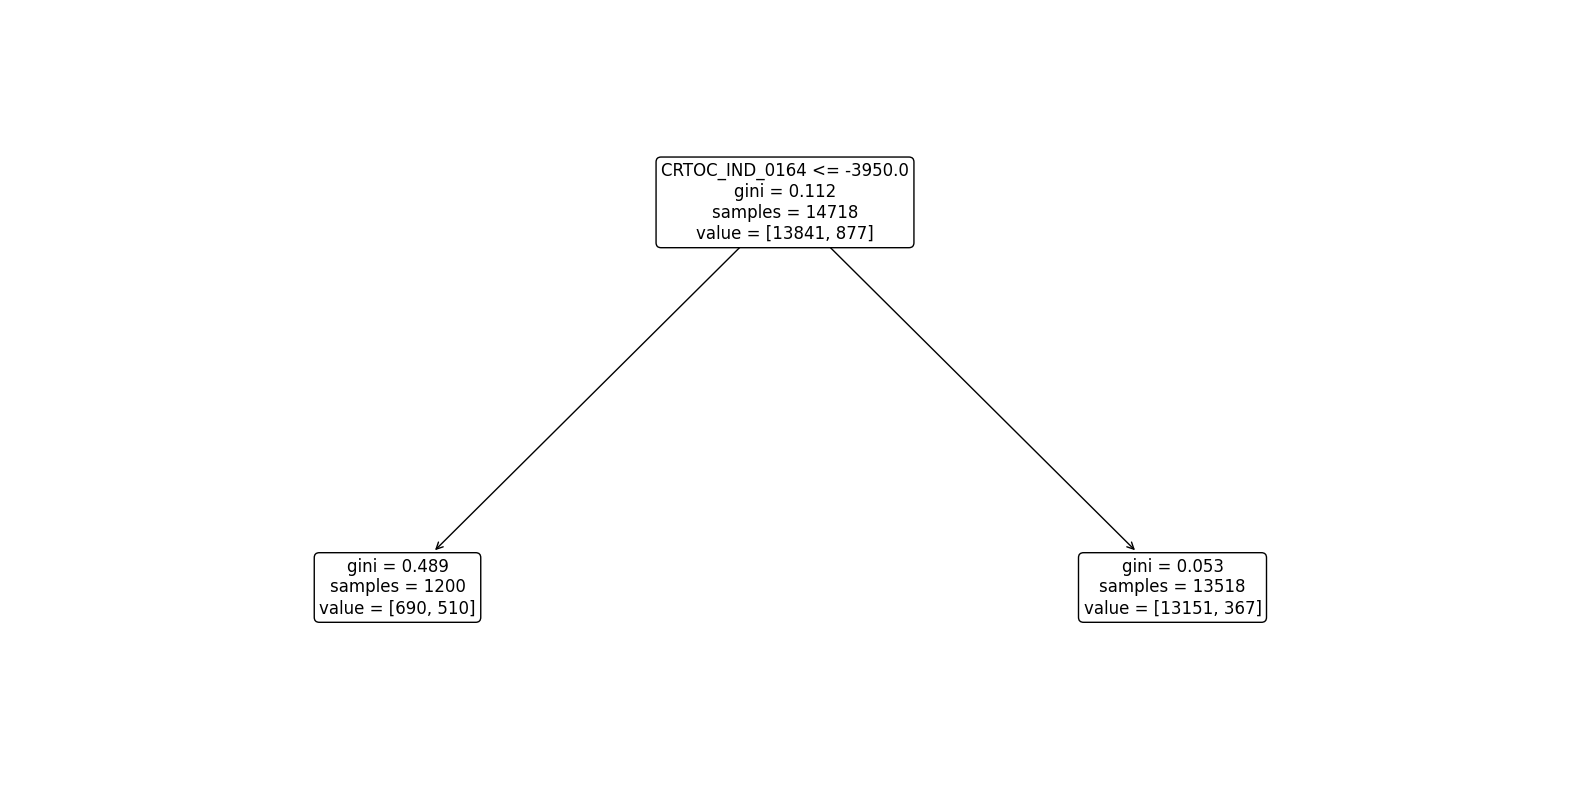

CRTOC_IND_0164_discretized
1    0.028221
0    0.431543
Name: DDefaut_NDB, dtype: float64


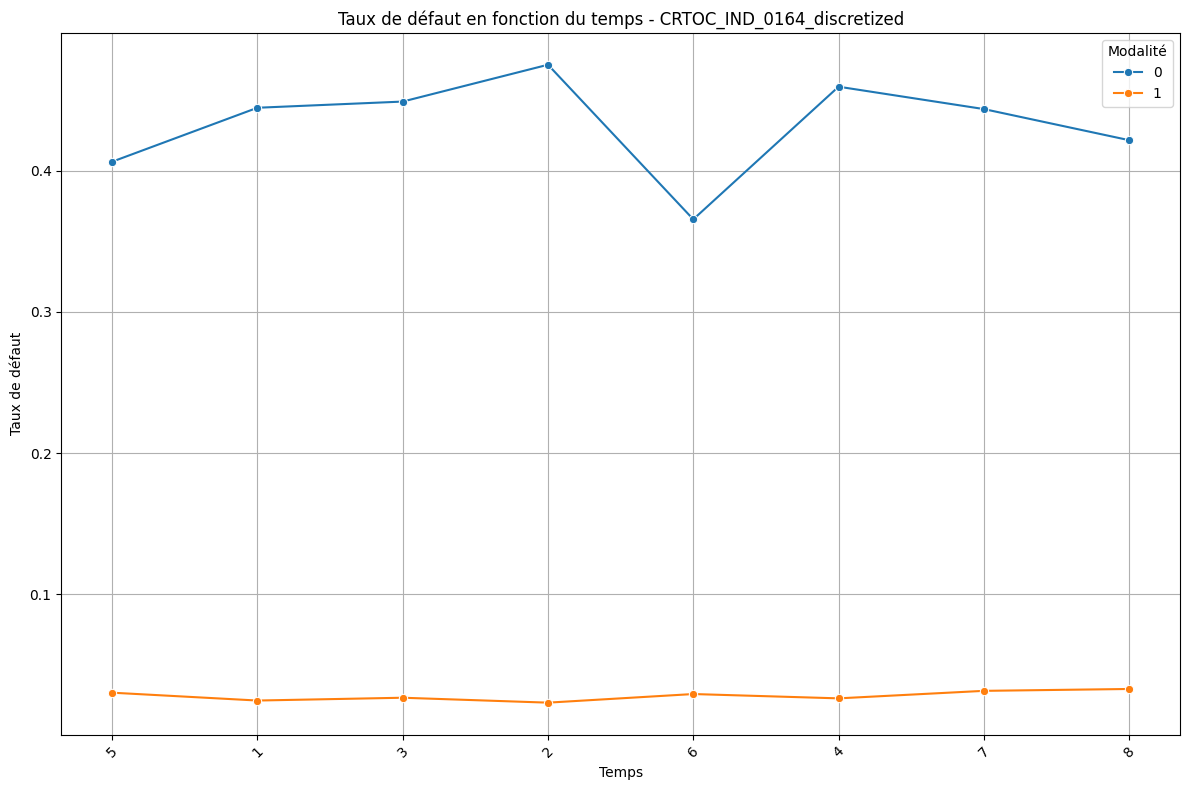

CRTOC_IND_0164_discretized
1    92.120611
0     7.879389
Name: proportion, dtype: float64


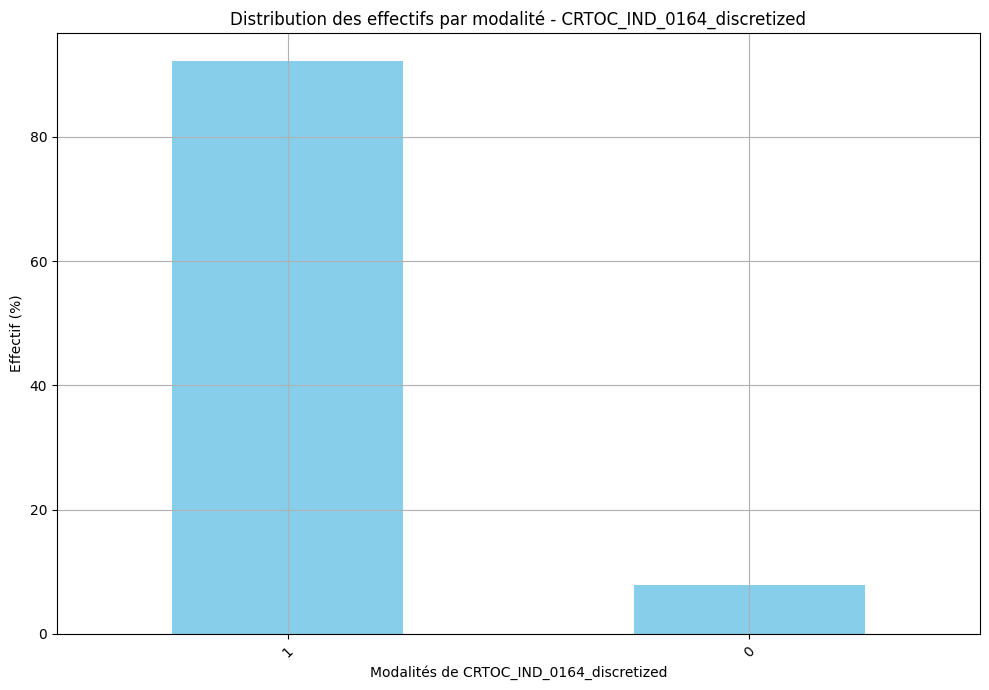

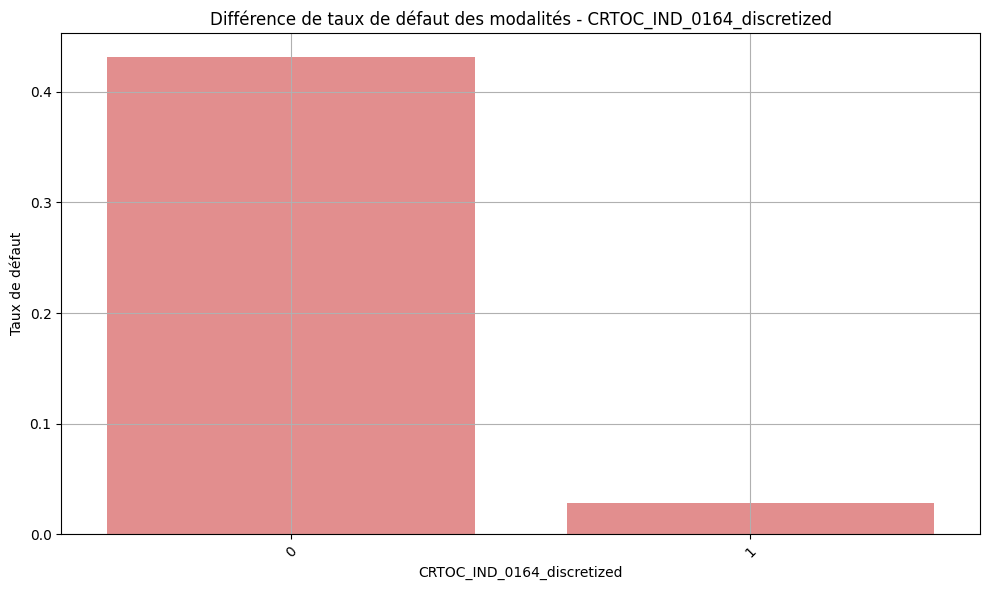

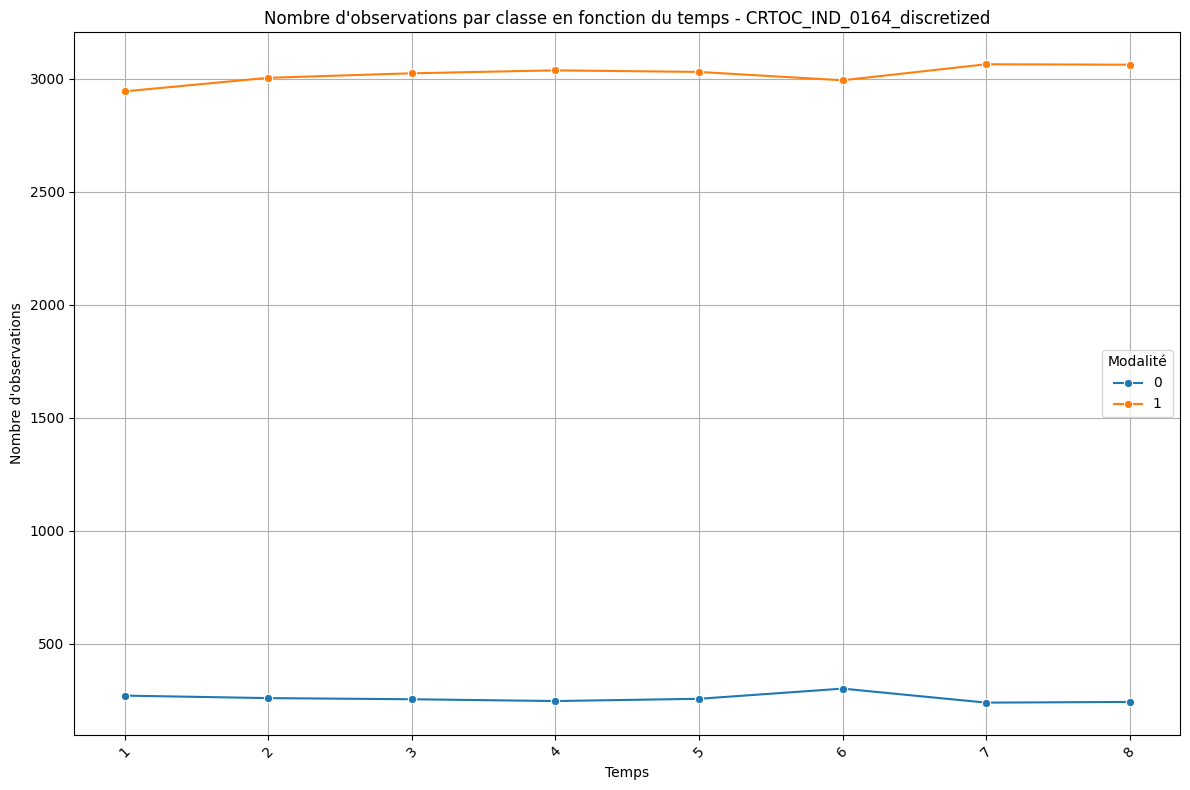

Seuils de coupure pour 'CRTOC_AG_NBJCRE_2T_IND_0009' : [11.5]


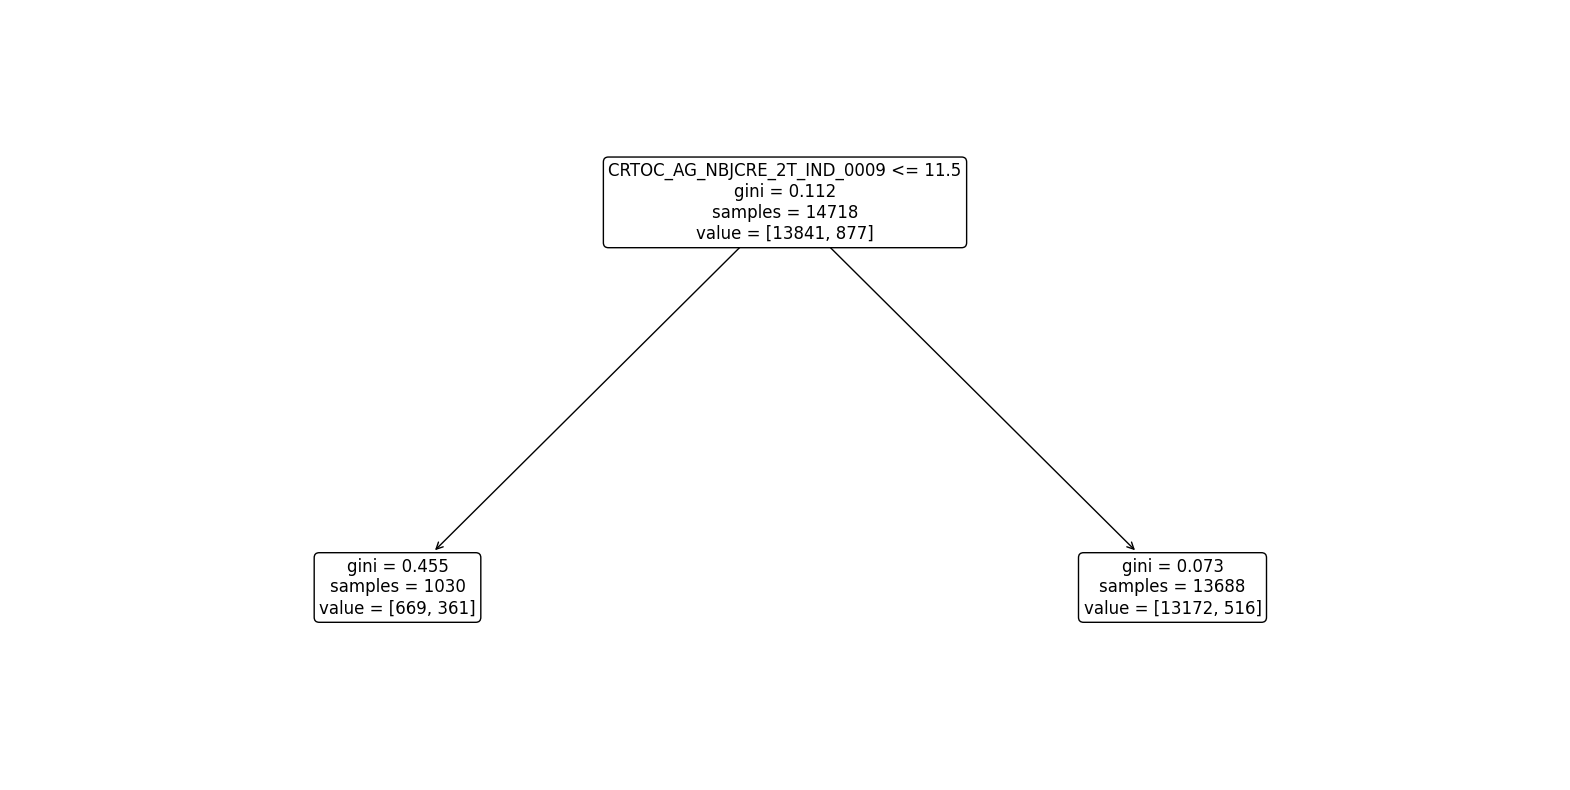

CRTOC_AG_NBJCRE_2T_IND_0009_discretized
1    0.037808
0    0.362319
Name: DDefaut_NDB, dtype: float64


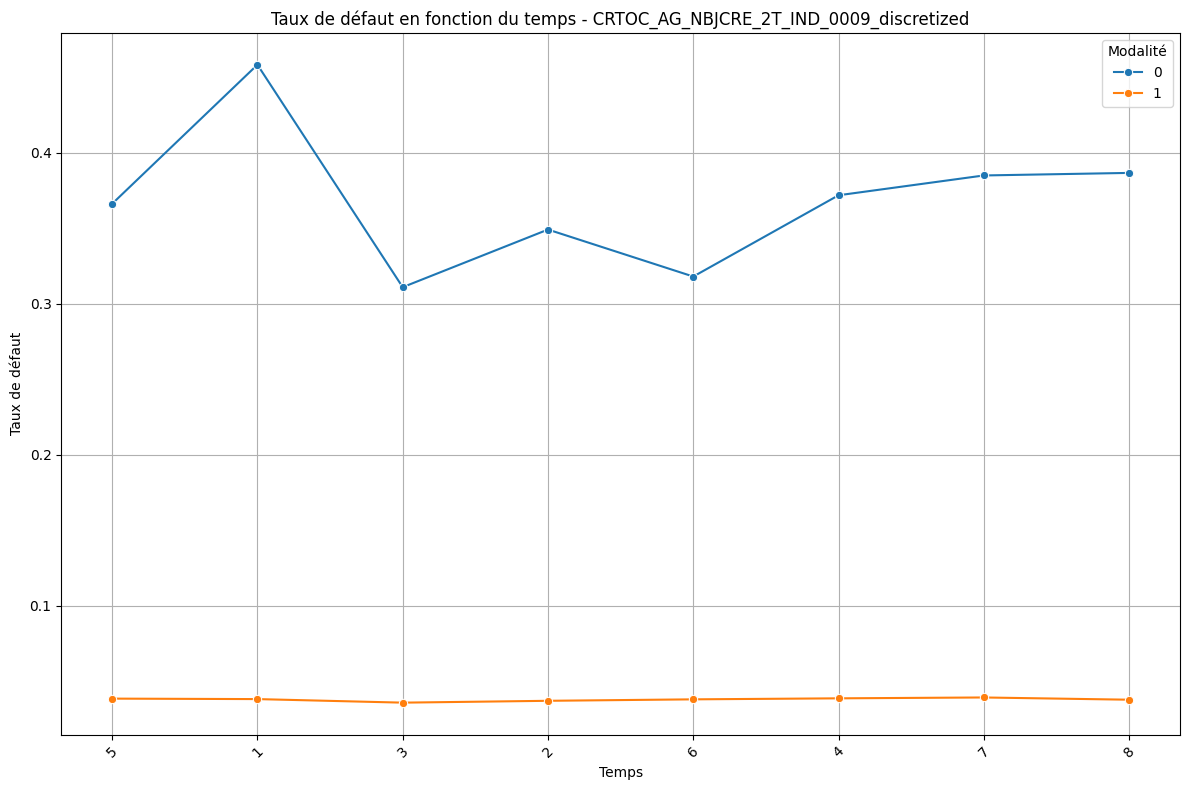

CRTOC_AG_NBJCRE_2T_IND_0009_discretized
1    93.161285
0     6.838715
Name: proportion, dtype: float64


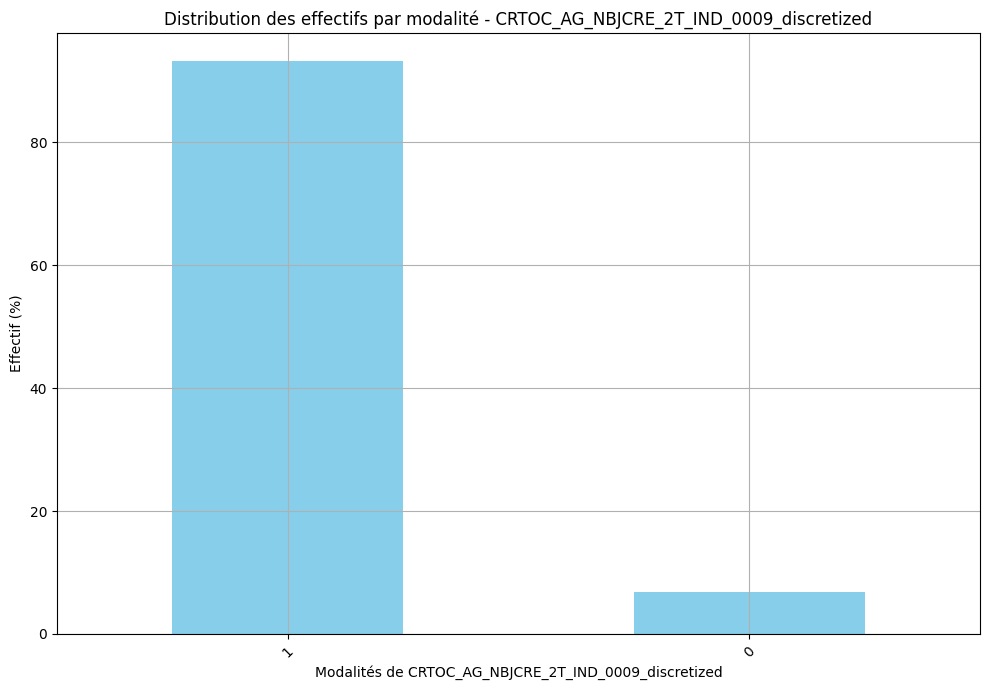

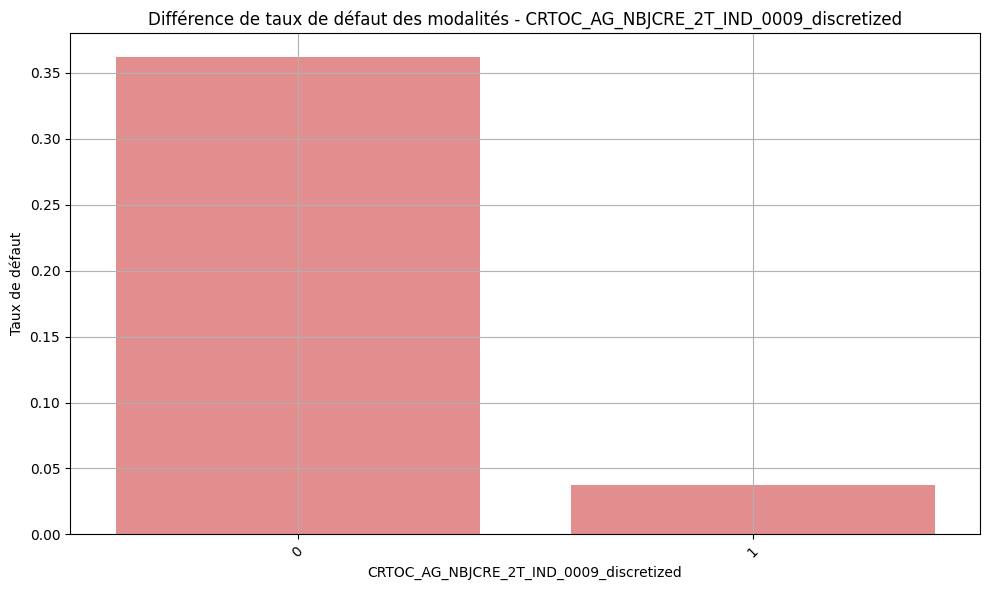

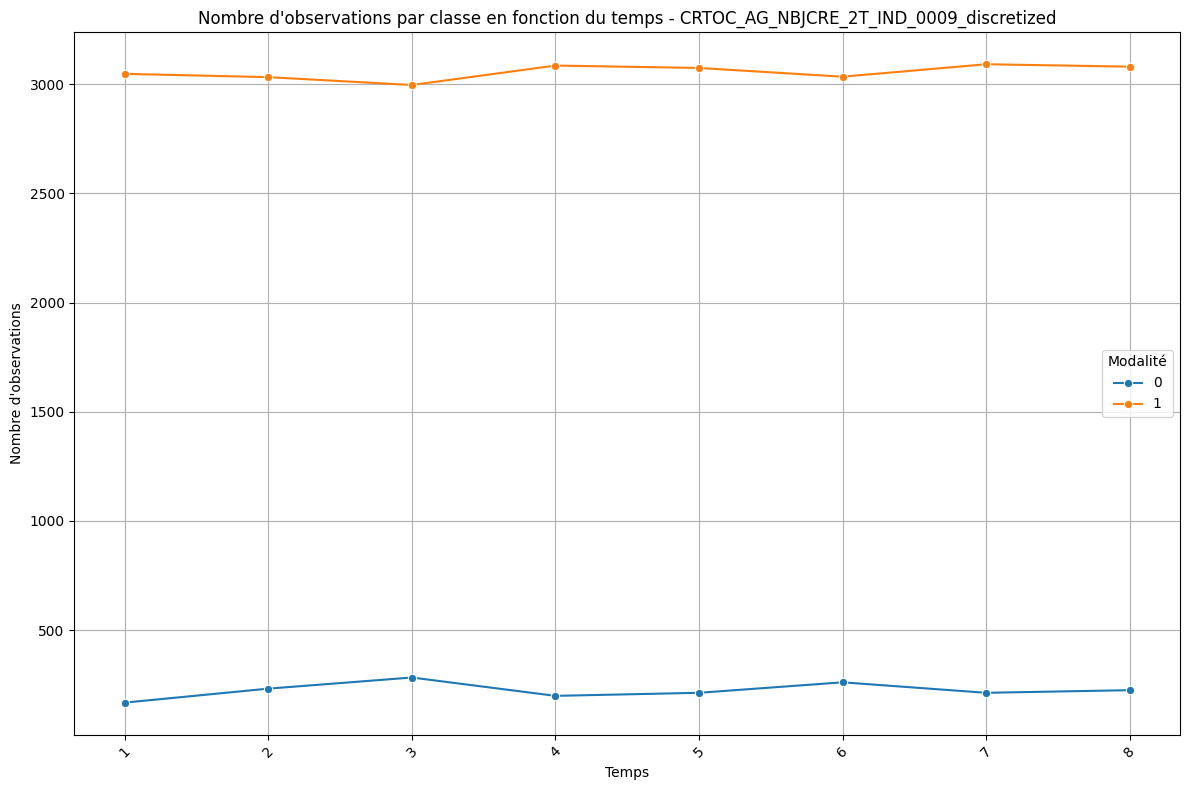

Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [  14156. 1811925.]


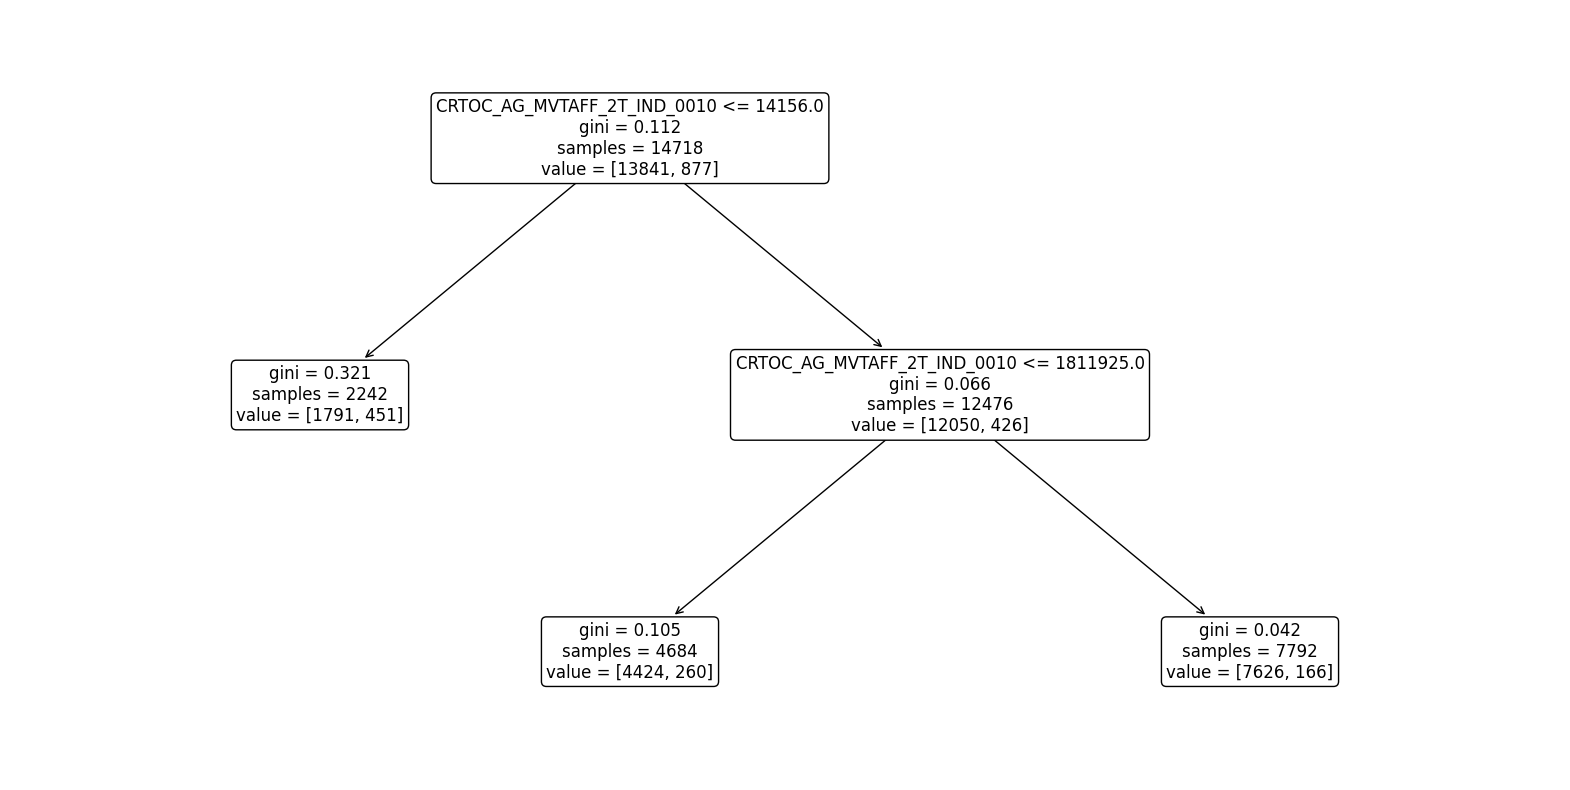

CRTOC_AG_MVTAFF_2T_IND_0010_discretized
2    0.019909
1    0.057656
0    0.205808
Name: DDefaut_NDB, dtype: float64


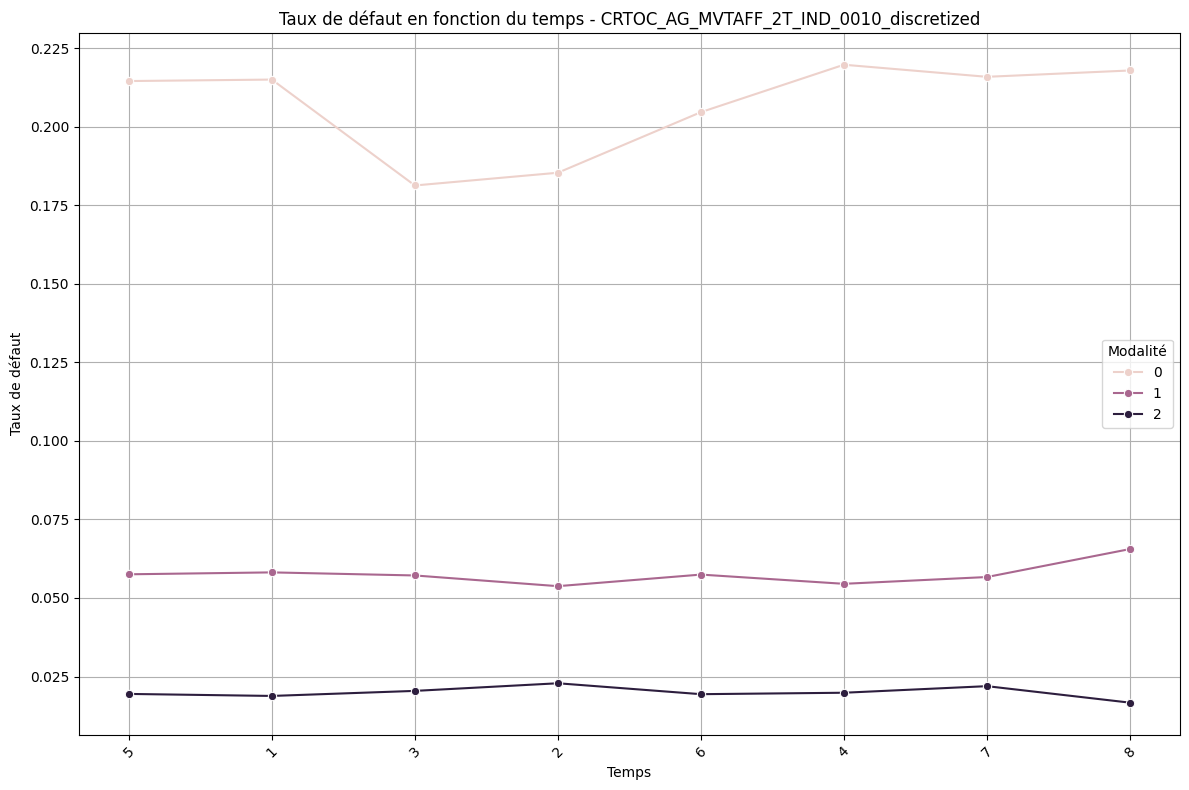

CRTOC_AG_MVTAFF_2T_IND_0010_discretized
2    53.036252
1    31.868258
0    15.095490
Name: proportion, dtype: float64


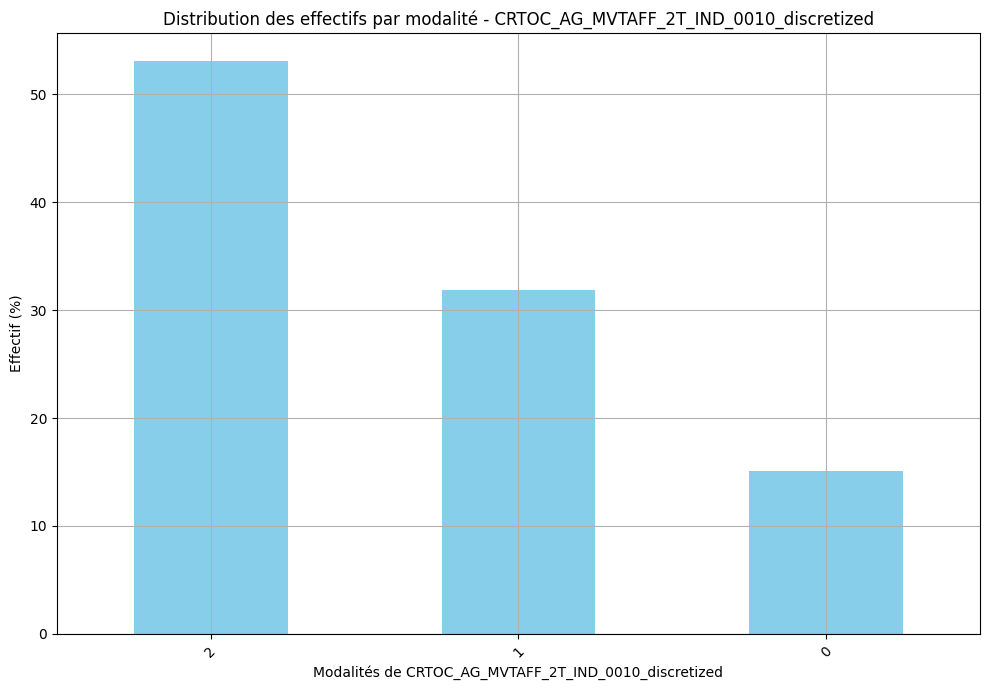

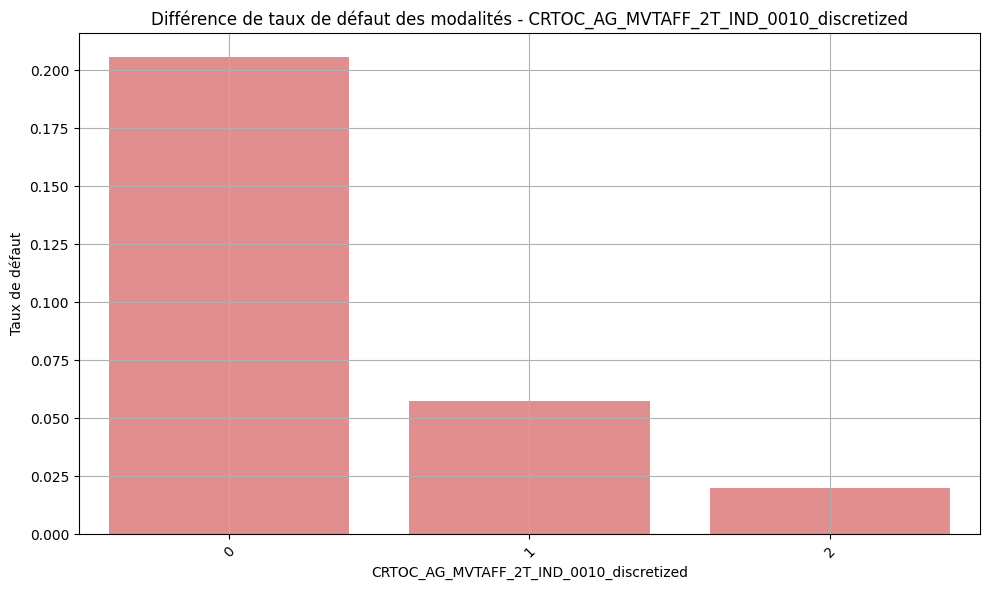

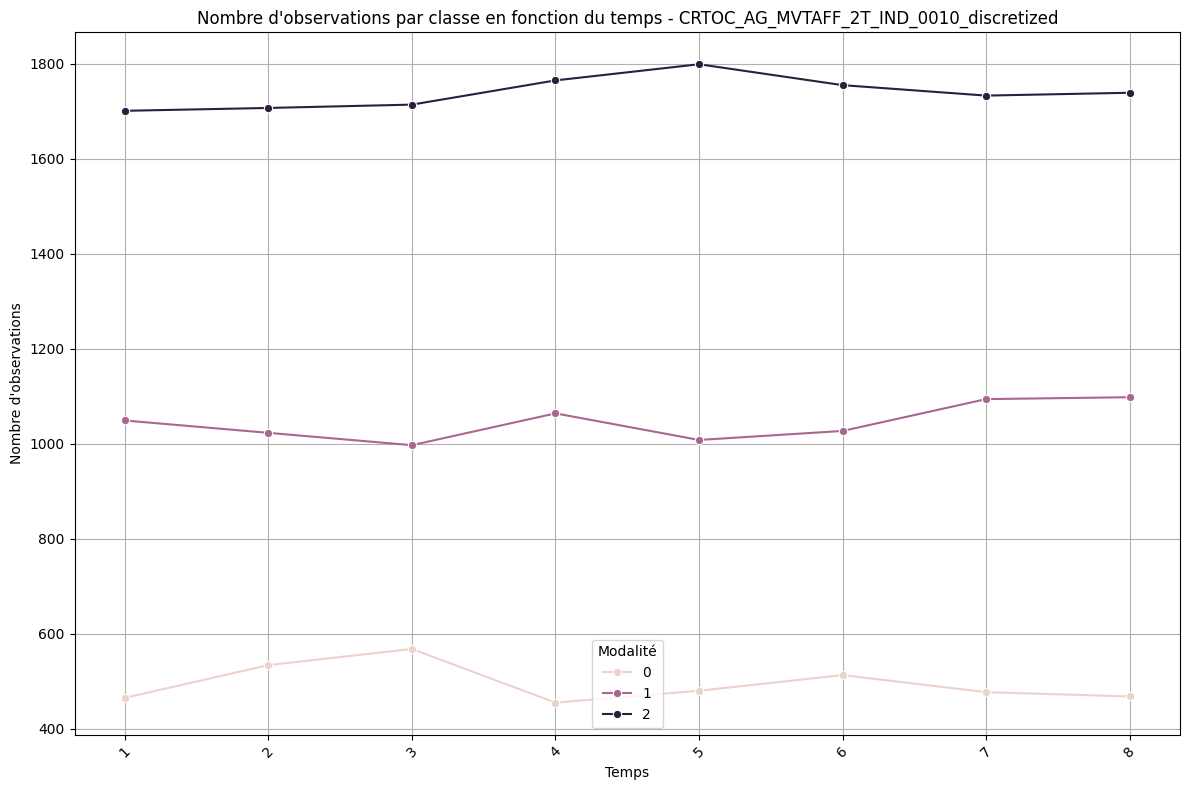

Seuils de coupure pour 'CRTOC_MOY_MVTAFF_IND_0010' : [4.950000e+01 1.527275e+05]


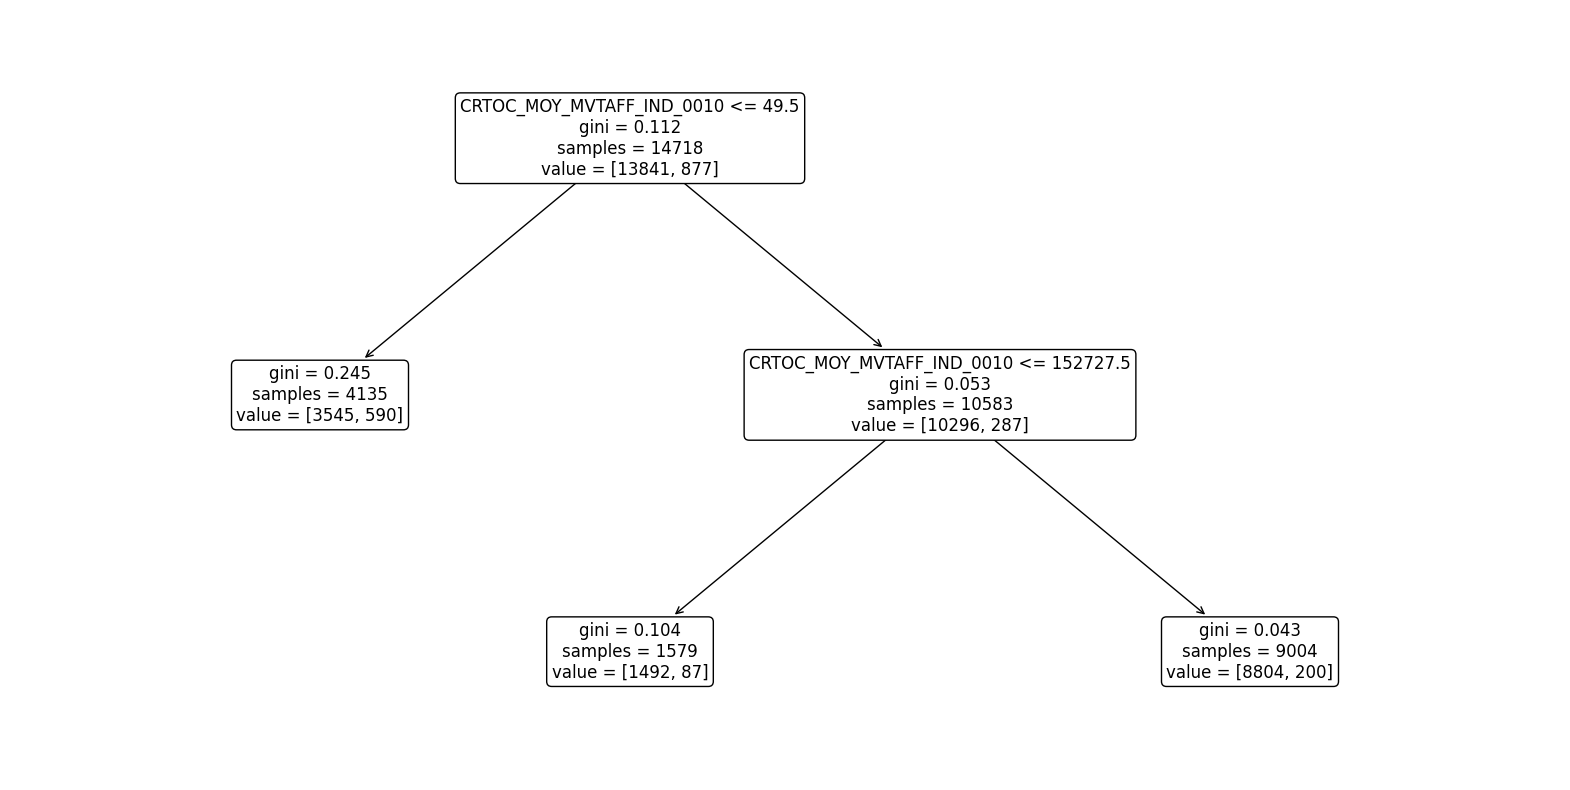

CRTOC_MOY_MVTAFF_IND_0010_discretized
2    0.022075
1    0.058549
0    0.144840
Name: DDefaut_NDB, dtype: float64


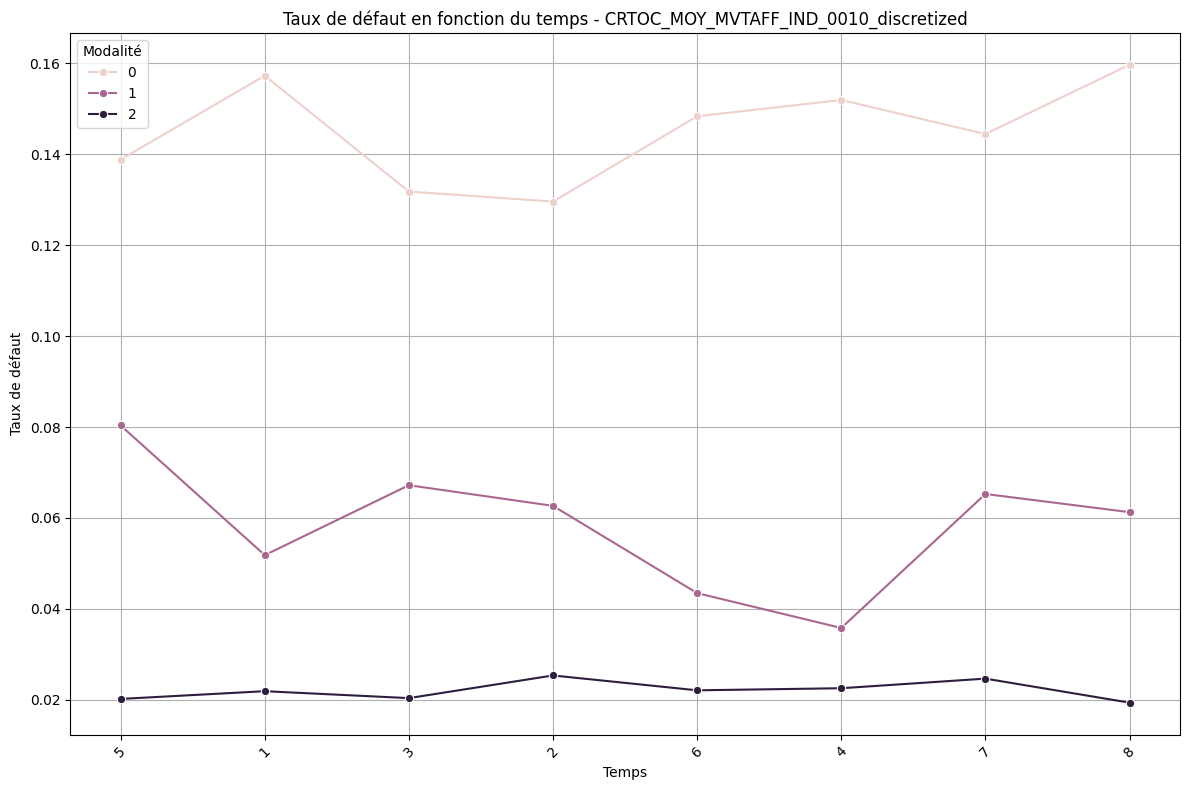

CRTOC_MOY_MVTAFF_IND_0010_discretized
2    61.647543
0    27.739870
1    10.612587
Name: proportion, dtype: float64


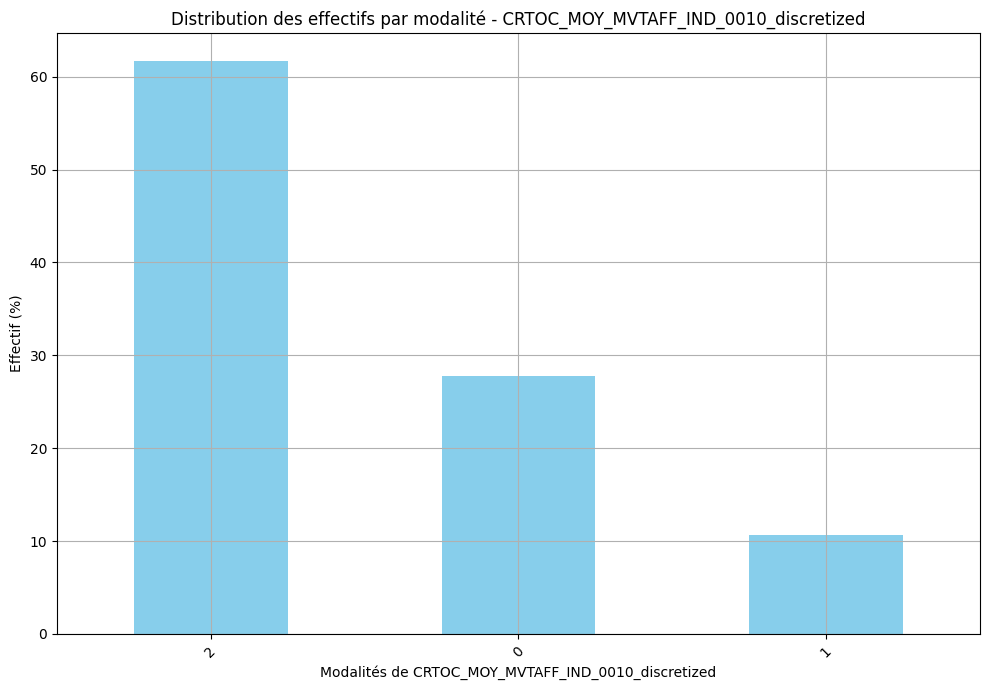

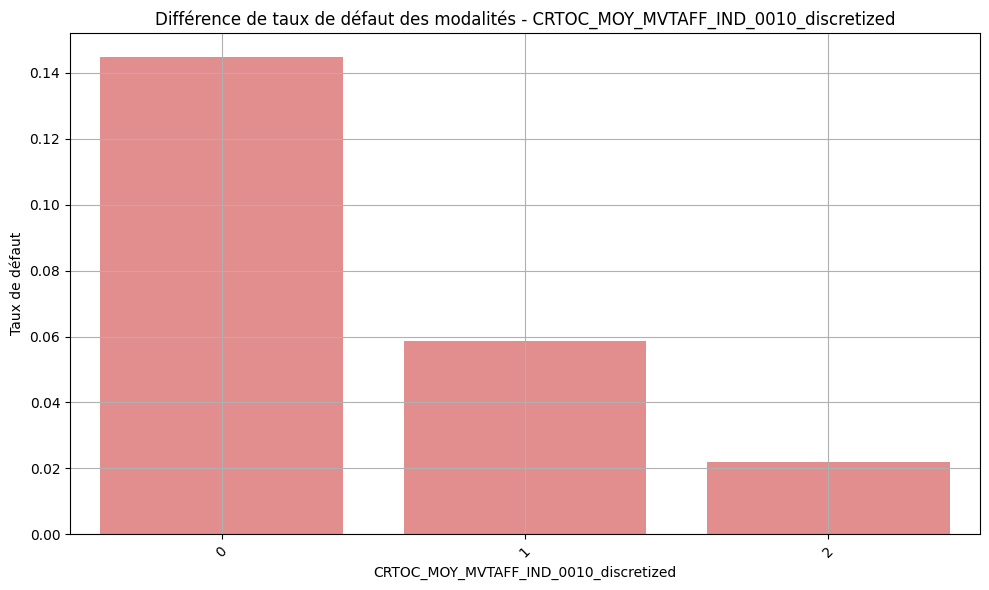

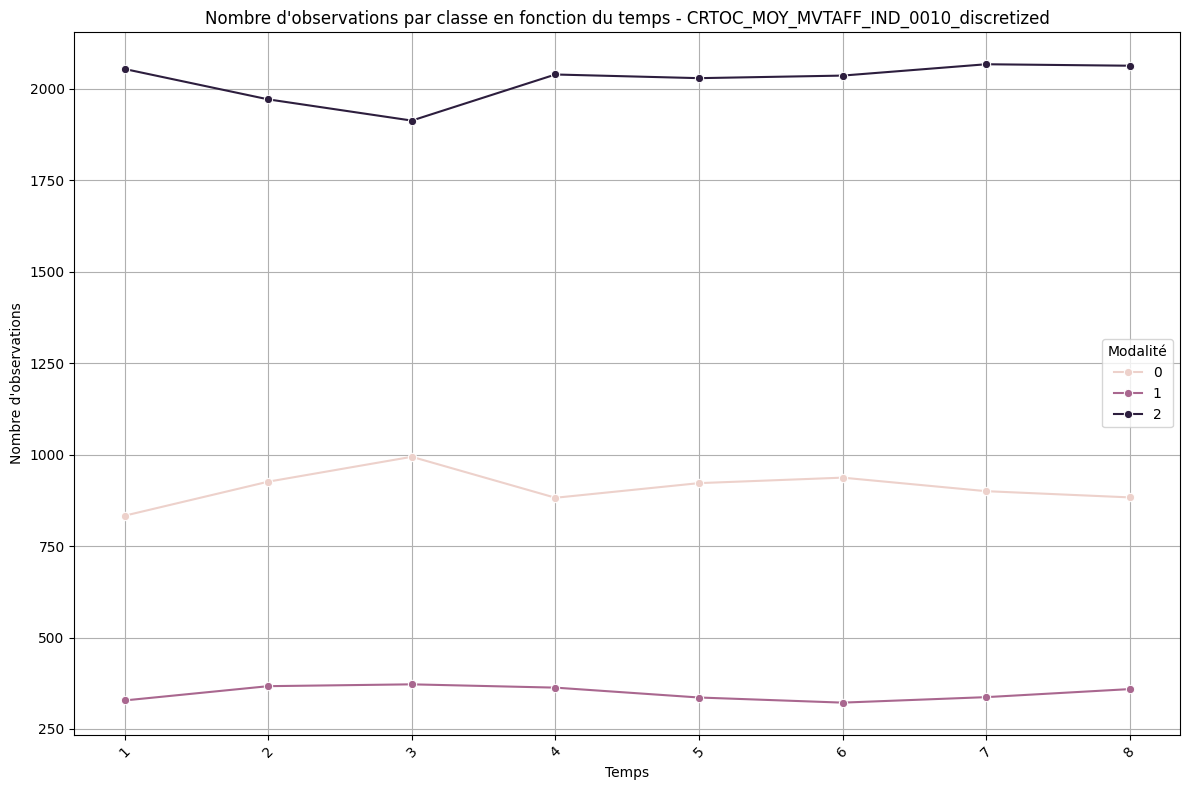

Seuils de coupure pour 'Score' : [230.5 459.  536.  695.5 789.5]


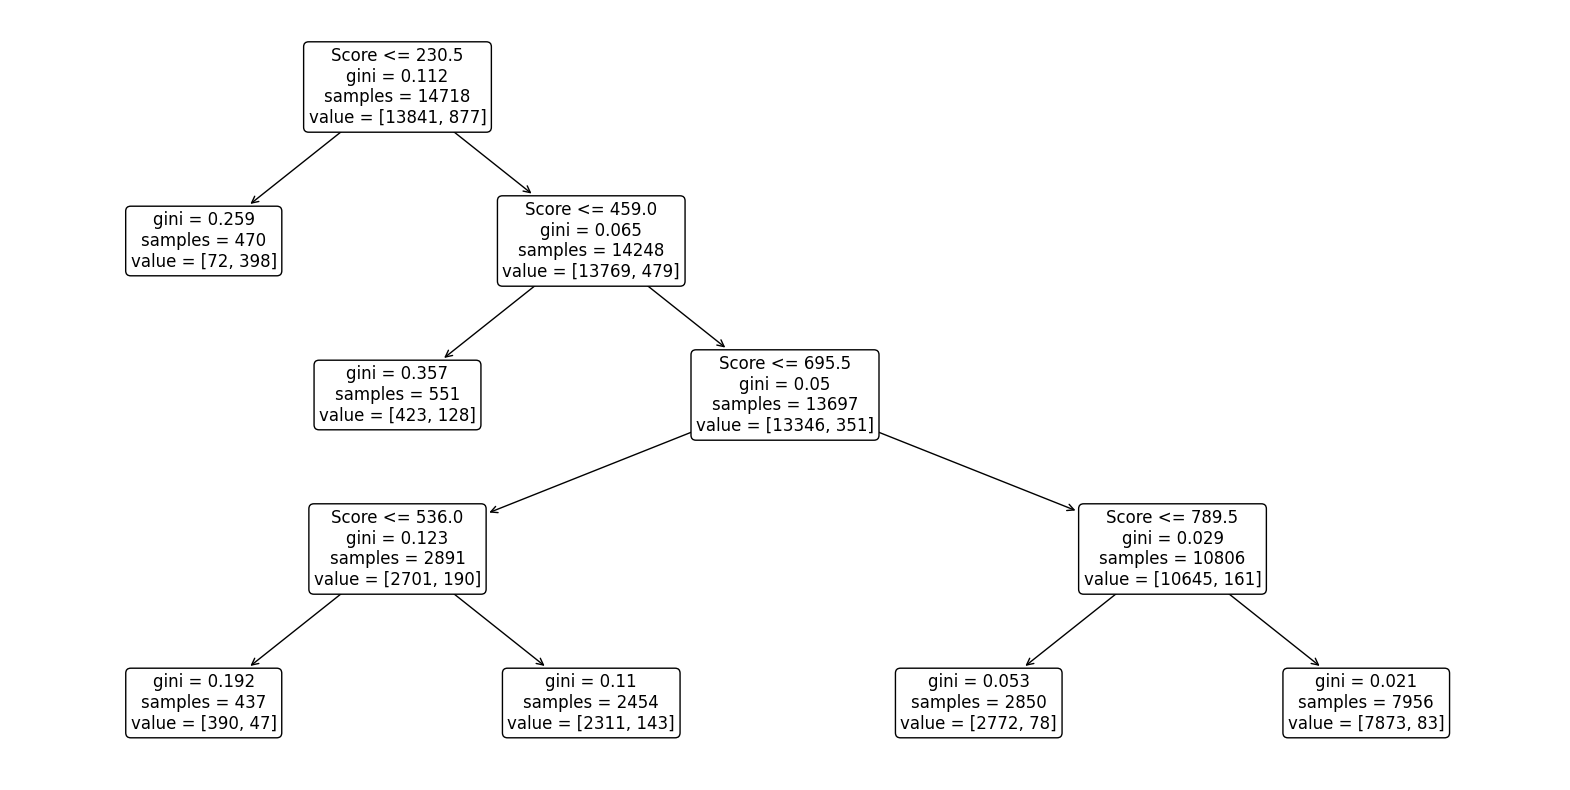

Score_discretized
5    0.010472
4    0.028793
3    0.060056
2    0.110226
1    0.233198
0    0.842043
Name: DDefaut_NDB, dtype: float64


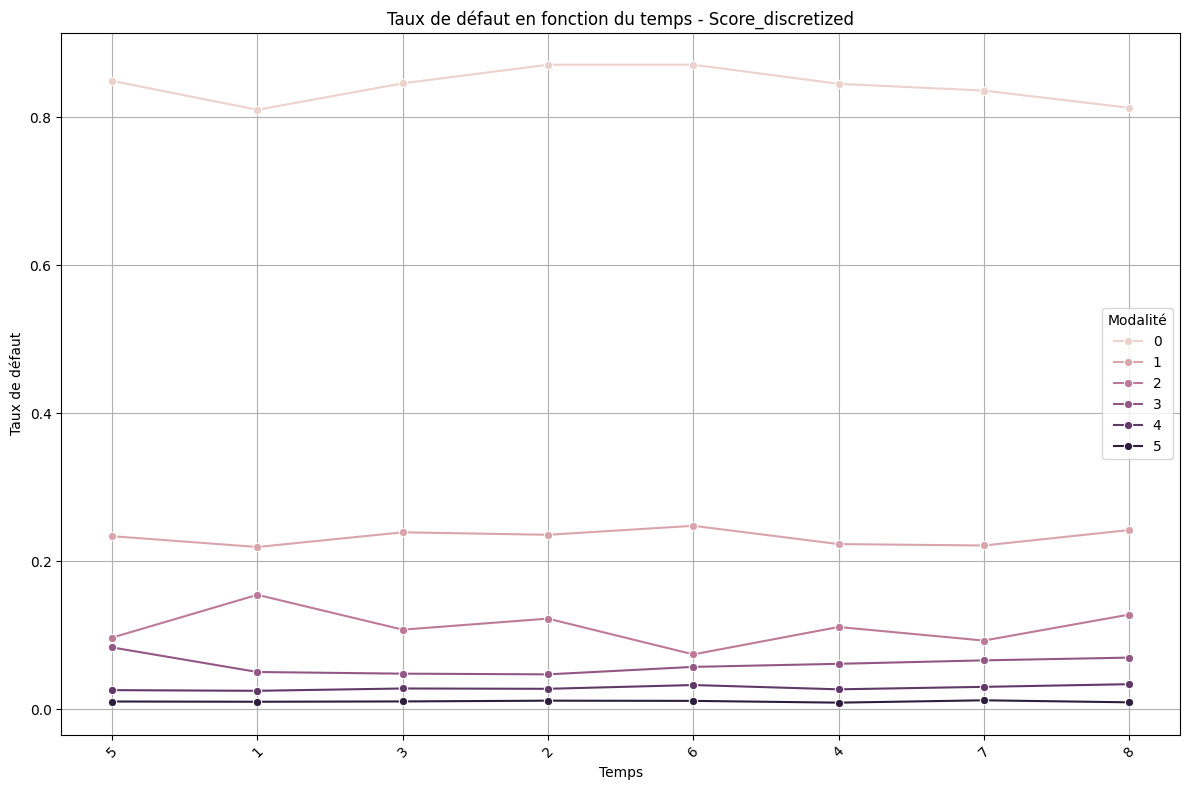

Score_discretized
5    54.602981
4    19.197194
3    16.376320
1     3.743377
0     3.209698
2     2.870430
Name: proportion, dtype: float64


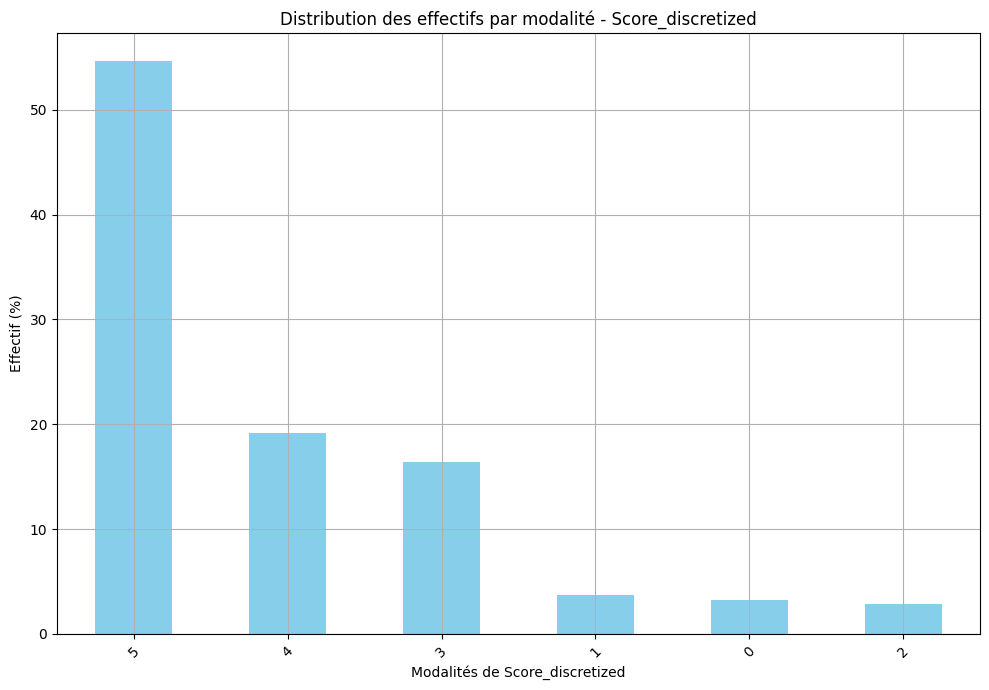

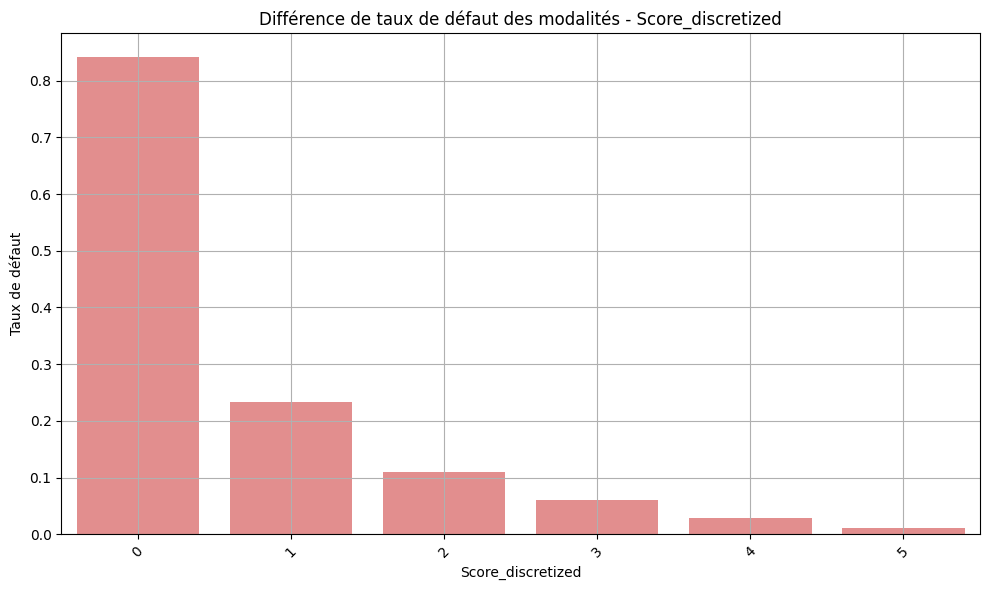

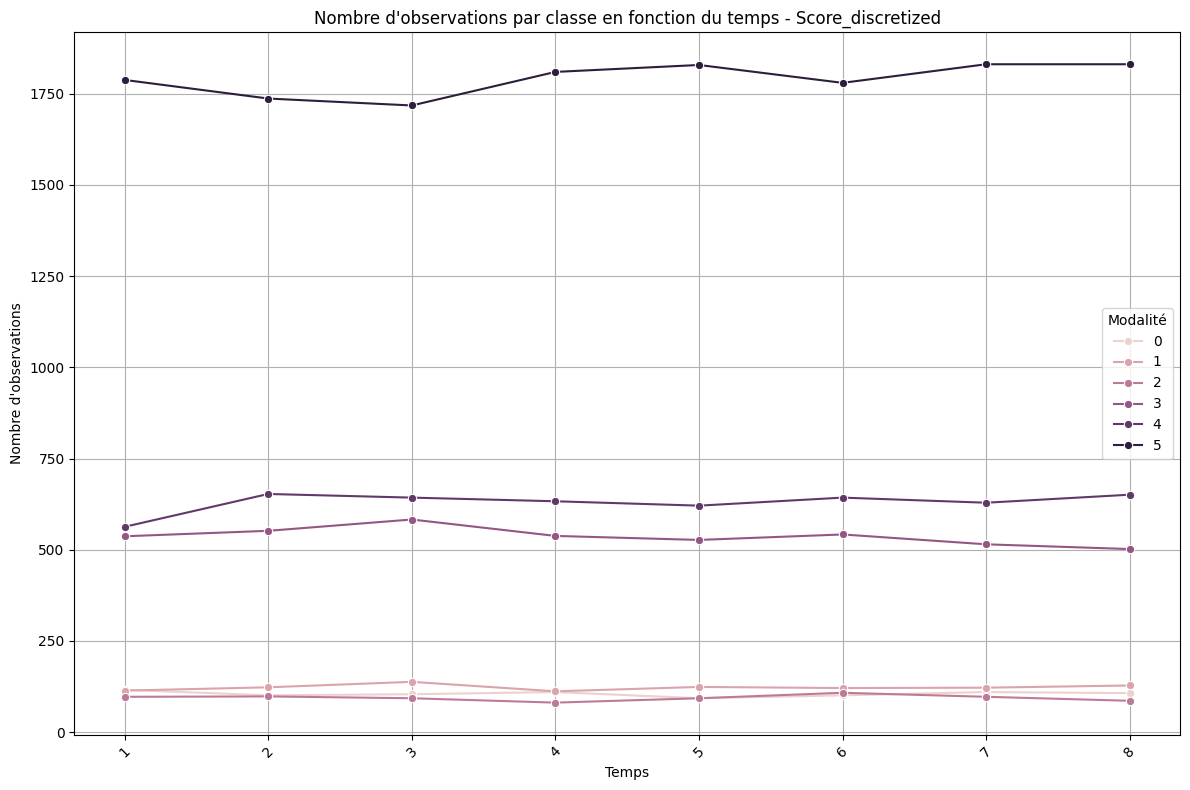

In [48]:
quantitative_cols_after_wallis_pearson = [
    'CRTOC_IND_0015', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_IND_0164',
    'CRTOC_AG_NBJCRE_2T_IND_0009', 'CRTOC_AG_MVTAFF_2T_IND_0010','CRTOC_MOY_MVTAFF_IND_0010', 'Score'
]

n_bins_list = [3, 2, 2, 2, 3, 3, 6]

for i in range(len(n_bins_list)):
    # Discretize the feature based on the tree method
    discretized_column_name = discretize_feature_based_on_tree(
        quantitative_cols_after_wallis_pearson[i], n_bins_list[i]
    )
    
    # Calculate the mean default rate for each discretized class
    taux_defaut = sample.groupby(discretized_column_name)["DDefaut_NDB"].mean().sort_values()
    print(taux_defaut)

    # Plot the default rate over time for each discretized group
    plt.figure(figsize=(12, 8))
    sns.lineplot(x="datdelhis", y="DDefaut_NDB", hue=discretized_column_name, data=sample, ci=None, marker='o')
    plt.title(f"Taux de défaut en fonction du temps - {discretized_column_name}")
    plt.xlabel("Temps")
    plt.ylabel("Taux de défaut")
    plt.grid(True)
    plt.legend(title="Modalité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Check stability by effect count (at least 5% per modality)
    modalites_count = sample[discretized_column_name].value_counts(normalize=True) * 100
    print(modalites_count)

    # Plot the distribution of counts by modality
    plt.figure(figsize=(10, 7))
    modalites_count.plot(kind="bar", color="skyblue")
    plt.title(f"Distribution des effectifs par modalité - {discretized_column_name}")
    plt.xlabel(f"Modalités de {discretized_column_name}")
    plt.ylabel("Effectif (%)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot the default rate difference between modalities for separation check
    plt.figure(figsize=(10, 6))
    sns.barplot(x=taux_defaut.index, y=taux_defaut.values, color="lightcoral")
    plt.title(f"Différence de taux de défaut des modalités - {discretized_column_name}")
    plt.xlabel(f"{discretized_column_name}")
    plt.ylabel("Taux de défaut")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculer le nombre d'observations par classe et par date
    observations_per_class_time = (
        sample.groupby(["datdelhis", discretized_column_name])
        .size()
        .reset_index(name="counts")
    )

    # Plot the number of observations per class over time
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        x="datdelhis", 
        y="counts", 
        hue=discretized_column_name, 
        data=observations_per_class_time, 
        marker='o', 
        ci=None
    )
    plt.title(f"Nombre d'observations par classe en fonction du temps - {discretized_column_name}")
    plt.xlabel("Temps")
    plt.ylabel("Nombre d'observations")
    plt.grid(True)
    plt.legend(title="Modalité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [49]:
# Arrondir les seuils:

# # Seuils de coupure pour 'CRTOC_IND_0015' : [ 3.5 27.5]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='CRTOC_IND_0015',
#     n_bins=3,
#     custom_thresholds=[4,28]
# )

# # Seuils de coupure pour 'ratio_jours_debiteurs' : [0.14776674]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='ratio_jours_debiteurs',
#     n_bins=2,
#     custom_thresholds=[0.15]
# )

# # Seuils de coupure pour 'ratio_jours_debiteurs' : [0.14776674]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='ratio_jours_debiteurs',
#     n_bins=2,
#     custom_thresholds=[0.15]
# )

# # Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [  14156. 1811925.]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='CRTOC_AG_MVTAFF_2T_IND_0010',
#     n_bins=3,
#     custom_thresholds=[14200, 1812000]
# )

# # Seuils de coupure pour 'CRTOC_MOY_MVTAFF_IND_0010' : [4.950000e+01 1.527275e+05]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='CRTOC_AG_MVTAFF_2T_IND_0010',
#     n_bins=3,
#     custom_thresholds=[4.95e+01, 1.527e+05]
# )

# #Seuils de coupure pour 'CRTOC_AG_LIGDEB_2T_IND_0015' : [-403533.5]
# discretized_column_name = discretize_feature_based_on_tree(
#     feature='CRTOC_AG_MVTAFF_2T_IND_0010',
#     n_bins=2,
#     custom_thresholds=[-403500]
# )


In [50]:
sample.head(5)

,id_client,DDefaut_NDB,datdelhis,AGEPRS,ANCIENNETE,CODETAJUR,CODITDBDF_PRO,CODNAF2,CRTAD_AG_MVTAFF_IND_0010,CRTAD_AG_NBECR_A,CRTAD_AG_NBECR_B,CRTAD_AG_NBJDE_BA,CRTAD_AG_NBJDE_BB,CRTAD_AG_NBJDE_BC,CRTAD_AG_SOLDE_IND_0009,CRTAD_AG_SOLDE_T,CRTAD_AG_SOLDE_T1,CRTAD_AG_SOLDE_T2,CRTAD_AG_SOLDE_T3,CRTAD_AG_SOLDE_T4,CRTAD_IND_0015,CRTAD_IND_0038,CRTAD_IND_0062,CRTAD_IND_0205,CRTAE_AG_SLDEPA,CRTAR_IND_0036,CRTOC_AG_LIGCRE_2T_IND_0009,CRTOC_AG_LIGCRE_IND_0009,CRTOC_AG_LIGDEB_2T_IND_0015,CRTOC_AG_LIGDEB_IND_0015,CRTOC_AG_MVTAFF_2T_IND_0010,CRTOC_AG_MVTAFF_IND_0010,CRTOC_AG_NBJCRE_2T_IND_0009,CRTOC_AG_NBJDEB_2T_IND_0015,CRTOC_AG_NBJDEB_IND_0015,CRTOC_IND_0010,CRTOC_IND_0015,CRTOC_IND_0164,CRTOC_IND_0301,CRTOC_MOY_MVTAFF_IND_0010,CRTOC_SLD_MOY,CRTOD_CMT_IND_0036,MINSOLDE_PAR,NBECR_PAR,CRTAD_IND_0042,CODACVPRO,DATCREPRSENT,ratio_debiteurs_3mois,ratio_ecritures,variation_soldes_moyens,mouvement_affaire_12mois,log_solde_moyen,ratio_age_anciennete,anciennete_diff_age,ratio_jours_debiteurs,var_jours_debiteurs_historique,var_nb_ecritures,ecritures_mvt_aff_ratio_diff,ratio_mvt_aff_soldes,var_soldes_moyens,solde_moyen_pondere,var_soldes_long_terme,ecart_sectoriel_solde,var_glissante_jours_debiteurs,moyenne_jours_debiteurs,dominance_crediteur,Score,CRTOC_IND_0015_discretized,CRTOC_AG_LIGDEB_2T_IND_0015_discretized,CRTOC_IND_0164_discretized,CRTOC_AG_NBJCRE_2T_IND_0009_discretized,CRTOC_AG_MVTAFF_2T_IND_0010_discretized,CRTOC_MOY_MVTAFF_IND_0010_discretized,Score_discretized
0,6002959649,0,5,0,256,5499,0,6920Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5061894013,1103084518,0,0,122271661,41858958,182,0,0,22273386,0,0,0,22273386,27812604,0,0,0,0,0,2002-06-01,NaN,0.0,NaN,3.488246e+06,NaN,0.0,256,0.0,0,0,NaN,-1.0,0,0.0,0,0.0,NaN,0.0,1,999,0,1,1,1,2,2,5
1,3235248704,0,1,0,16,5498,0,7022Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33100645,6430323,0,0,956444,373516,184,0,0,405332,0,42000,0,405332,179895,0,0,0,0,0,2021-09-01,NaN,0.0,NaN,3.112633e+04,NaN,0.0,16,0.0,0,0,NaN,-1.0,0,0.0,0,0.0,NaN,0.0,1,893,0,1,1,1,1,2,5
2,7995781136,0,3,0,22,5710,0,7022Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36707689,5820641,0,0,700000,200000,184,0,0,300000,0,285800,0,300000,199498,0,0,0,0,0,2021-01-04,NaN,0.0,NaN,1.666667e+04,NaN,0.0,22,0.0,0,0,NaN,-1.0,0,0.0,0,0.0,0.0,0.0,1,893,0,1,1,1,1,2,5
3,2112452922,0,5,0,85,5710,0,7022Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3957245204,728095628,0,0,6360000,2192800,182,0,0,393600,0,24665500,0,393600,21743106,0,0,0,0,0,2016-03-25,NaN,0.0,NaN,1.827333e+05,NaN,0.0,85,0.0,0,0,NaN,-1.0,0,0.0,0,0.0,0.0,0.0,1,999,0,1,1,1,2,2,5
4,3540500580,0,2,0,42,5710,0,6202A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2213841782,399495826,0,0,4176900,1419075,184,0,0,1570800,0,14863200,0,1570800,12031749,0,0,0,0,0,2019-09-17,NaN,0.0,NaN,1.182562e+05,NaN,0.0,42,0.0,0,0,NaN,-1.0,0,0.0,0,0.0,0.0,0.0,1,999,0,1,1,1,2,2,5


In [51]:
sample.columns

Index(['id_client', 'DDefaut_NDB', 'datdelhis', 'AGEPRS', 'ANCIENNETE', 'CODETAJUR', 'CODITDBDF_PRO', 'CODNAF2', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_NBECR_A', 'CRTAD_AG_NBECR_B', 'CRTAD_AG_NBJDE_BA', 'CRTAD_AG_NBJDE_BB', 'CRTAD_AG_NBJDE_BC', 'CRTAD_AG_SOLDE_IND_0009', 'CRTAD_AG_SOLDE_T', 'CRTAD_AG_SOLDE_T1', 'CRTAD_AG_SOLDE_T2', 'CRTAD_AG_SOLDE_T3', 'CRTAD_AG_SOLDE_T4', 'CRTAD_IND_0015', 'CRTAD_IND_0038', 'CRTAD_IND_0062', 'CRTAD_IND_0205', 'CRTAE_AG_SLDEPA', 'CRTAR_IND_0036', 'CRTOC_AG_LIGCRE_2T_IND_0009', 'CRTOC_AG_LIGCRE_IND_0009', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_AG_LIGDEB_IND_0015', 'CRTOC_AG_MVTAFF_2T_IND_0010', 'CRTOC_AG_MVTAFF_IND_0010', 'CRTOC_AG_NBJCRE_2T_IND_0009', 'CRTOC_AG_NBJDEB_2T_IND_0015', 'CRTOC_AG_NBJDEB_IND_0015', 'CRTOC_IND_0010', 'CRTOC_IND_0015', 'CRTOC_IND_0164', 'CRTOC_IND_0301', 'CRTOC_MOY_MVTAFF_IND_0010', 'CRTOC_SLD_MOY', 'CRTOD_CMT_IND_0036', 'MINSOLDE_PAR', 'NBECR_PAR', 'CRTAD_IND_0042', 'CODACVPRO', 'DATCREPRSENT', 'ratio_debiteurs_3mois',
       '

In [52]:
dict = {'CRTOC_AG_MVTAFF_2T_IND_0010_discretized': 'CRTOC_AG_MVTAFF_2T_IND_0010', 
        'CRTOC_AG_NBJCRE_2T_IND_0009_discretized': 'CRTOC_AG_NBJCRE_2T_IND_0009', 
        'CRTOC_IND_0164_discretized':'CRTOC_IND_0164', 
        'CRTOC_AG_LIGDEB_2T_IND_0015_discretized':'CRTOC_AG_LIGDEB_2T_IND_0015', 
        'CRTOC_IND_0015_discretized':'CRTOC_IND_0015',
        'CRTOC_MOY_MVTAFF_IND_0010_discretized':'CRTOC_MOY_MVTAFF_IND_0010', 
        'Score_discretized':'Score'}

for key, value in dict.items():
    grouped = sample.groupby(key).agg( 
        min=(value, 'min'),  
        max=(value, 'max') 
    ).reset_index()
    print(grouped)

   CRTOC_AG_MVTAFF_2T_IND_0010_discretized      min         max
0                                        0        0       14050
1                                        1    14272     1811510
2                                        2  1812340  3083658410
   CRTOC_AG_NBJCRE_2T_IND_0009_discretized  min   max
0                                        0    0    11
1                                        1   12  4914
   CRTOC_IND_0164_discretized       min         max
0                           0 -78662600       -4000
1                           1     -3900  2145744400
   CRTOC_AG_LIGDEB_2T_IND_0015_discretized           min     max
0                                        0 -109119564301 -403567
1                                        1       -403500       0
   CRTOC_IND_0015_discretized  min  max
0                           0    0    3
1                           1    4   27
2                           2   28   31
   CRTOC_MOY_MVTAFF_IND_0010_discretized     min        max
0          

In [53]:
quanti_discretized_sample = sample[['id_client', 'datdelhis', 'CRTOC_AG_MVTAFF_2T_IND_0010_discretized', 'CRTOC_AG_NBJCRE_2T_IND_0009_discretized', 'CRTOC_IND_0164_discretized', 'CRTOC_AG_LIGDEB_2T_IND_0015_discretized', 'CRTOC_IND_0015_discretized','CRTOC_MOY_MVTAFF_IND_0010_discretized']]
quanti_discretized_sample = quanti_discretized_sample.rename(columns={'CRTOC_AG_MVTAFF_2T_IND_0010_discretized': 'CRTOC_AG_MVTAFF_2T_IND_0010', 
                                                                      'CRTOC_AG_NBJCRE_2T_IND_0009_discretized': 'CRTOC_AG_NBJCRE_2T_IND_0009', 
                                                                      'CRTOC_IND_0164_discretized':'CRTOC_IND_0164', 
                                                                      'CRTOC_AG_LIGDEB_2T_IND_0015_discretized':'CRTOC_AG_LIGDEB_2T_IND_0015', 
                                                                      'CRTOC_IND_0015_discretized':'CRTOC_IND_0015',
                                                                      'CRTOC_MOY_MVTAFF_IND_0010_discretized':'CRTOC_MOY_MVTAFF_IND_0010'})
quanti_discretized_sample.head(10)

,id_client,datdelhis,CRTOC_AG_MVTAFF_2T_IND_0010,CRTOC_AG_NBJCRE_2T_IND_0009,CRTOC_IND_0164,CRTOC_AG_LIGDEB_2T_IND_0015,CRTOC_IND_0015,CRTOC_MOY_MVTAFF_IND_0010
0,6002959649,5,2,1,1,1,0,2
1,3235248704,1,1,1,1,1,0,2
2,7995781136,3,1,1,1,1,0,2
3,2112452922,5,2,1,1,1,0,2
4,3540500580,2,2,1,1,1,0,2
5,8390775990,6,2,1,1,1,0,2
6,1528496440,3,0,1,1,1,0,0
7,3019876475,2,2,1,1,1,0,2
8,1500330744,3,2,1,1,0,0,2
9,3549117482,2,2,1,1,1,0,2


In [54]:
quanti_discretized_sample.to_excel('../data/quanti_discretized_sample.xlsx', index=False)